In [1]:
#for importing, formatting and data manipulation
import pandas as pd
import numpy as np
import glob
import datetime
#from time import time
#from datetime import datetime
#from datetime import timedelta
import tempfile
from qiime2 import Artifact
import zipfile
import yaml
import json

#for plotting
import matplotlib, random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_venn import venn3, venn3_circles
from matplotlib.patches import Patch
import seaborn as sns
#sns.set(style="whitegrid")
import plotly.express as px
%matplotlib inline
from IPython.display import display
from upsetplot import plot
#import pyupset as pyu
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()

#for statistical analyses
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from skbio.diversity import alpha_diversity
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
from scipy.spatial.distance import cdist
from skbio.stats.composition import clr
from skbio.stats.composition import alr
from skbio.stats.composition import ilr
from skbio.diversity.alpha import chao1
from skbio.stats.composition import ancom
import scipy.stats as stats
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

## Import and format metadata from lab, and BBMP

### Import lab metadata

In [2]:
def load_df():
    
    filenames = glob.glob('/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/METADATA.txt')
    #load 2022 metadata and concatenate it into one dataframe
    md = []
    for filename in filenames:
        df = pd.read_csv(filename, sep='\t')
        md.append(df)
        print (filename)
    
    md = pd.concat(md)
    
    #drop empty columns and rows
    md.dropna(how='all', axis=1, inplace=True) #empty cols
    md.dropna(how='all', inplace=True) #empty rows
    
    return md

In [3]:
md = load_df()
#md = md[["sampleid", "[DNA]ng/ul", "A260/280"]].copy()

/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/METADATA.txt


Modified version of load_df() to accomodate different metadata files specific to the size fractioning samples.

In [4]:
def load_df():
    
    filenames = glob.glob('/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/*.csv')
    #load all metadata from 2022 folder and concatenate them.
    md = []
    for filename in filenames:
        df = pd.read_csv(filename)
        df = df.rename(columns={'Depth Code 1-A, 5-B, 10-C, 60-D': 'depth_code',
                            'Size Code 3um - L 0.2um - S': 'size_code'}) 
        md.append(df)
        print (filename)
    
    md = pd.concat(md)
    
    #drop empty columns and rows
    md.dropna(how='all', axis=1, inplace=True) #empty cols
    md.dropna(how='all', inplace=True) #empty rows
    
    return md

In [5]:
mdsf = load_df()

/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/a260230.csv
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/noSF.csv
/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/SF.csv


In [6]:
#upload the absorbance per sample data
df = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/a260230.csv")
df = df.dropna(how='all') #drop null rows and columns
df.dropna(how='all', axis=1, inplace=True)
df = df.replace({pd.NA: np.nan})

In [7]:
#upload metadata of non size fractionated samples
df1 = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/noSF.csv")
df1 = df1.dropna(how='all')
df1.dropna(how='all', axis=1, inplace=True)
df1 = df1.replace({pd.NA: np.nan})
df1 = df1.dropna(how='all') #drop null rows and columns
df1 = df1[["sampleid", "[DNA]ng/ul", "A260/280", "date"]]

In [8]:
#upload metadata of size fractionated samples
df2 = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/2022/SF.csv")
df2 = df2.dropna(how='all')
df2.dropna(how='all', axis=1, inplace=True)
df2 = df2.replace({pd.NA: np.nan})
df2 = df2.rename(columns={'Depth Code 1-A, 5-B, 10-C, 60-D': 'depth_code',
                            'Size Code 3um - L 0.2um - S': 'size_code'}) 
df2 = df2[["sampleid", "[DNA]ng/ul", "A260/280", "date"]]

In [9]:
#verify which columns are shared between two dataframes
a = np.intersect1d(mdsf.columns, df2.columns)
a

array(['A260/280', '[DNA]ng/ul', 'date', 'sampleid'], dtype=object)

In [10]:
#fill missing cell values with matching column name from other dataframe
df = df.fillna(df1)

In [11]:
df1 = df1.fillna(df)

In [12]:
mdsf = df.merge(df1, on=['sampleid', '[DNA]ng/ul', 'A260/280'], how='outer')

In [13]:
mdsf["weekn"] = mdsf["sampleid"].str.extract(r'\.([1-9][0-9]?)[A-E]')
mdsf['weekn'] = pd.to_numeric(mdsf['weekn'])
mdsf['date'] = mdsf.groupby(['weekn'], sort=False)['date'].apply(lambda x: x.ffill().bfill())

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_17466/4232994767.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mdsf['date'] = mdsf.groupby(['weekn'], sort=False)['date'].apply(lambda x: x.ffill().bfill())


In [14]:
mdsf

sampleid extraction_date  [DNA]ng/ul  A260/280  A260/230    date  weekn
0     BB22.10A      2023-07-31        54.8      1.89      2.02  16-Mar   10.0
1    BB22.10AL      2023-07-31         8.9      1.71      1.47  16-Mar   10.0
2    BB22.10AS      2023-07-31        29.9      1.92      1.95  16-Mar   10.0
3     BB22.10B      2023-07-31        52.2      1.93      2.14  16-Mar   10.0
4    BB22.10BL      2023-07-31        17.0      1.83      1.72  16-Mar   10.0
..         ...             ...         ...       ...       ...     ...    ...
403   BB22.50A             NaN         NaN       NaN       NaN  21-Dec   50.0
404   BB22.50B             NaN         NaN       NaN       NaN  21-Dec   50.0
405   BB22.50C             NaN         NaN       NaN       NaN  21-Dec   50.0
406   BB22.50E             NaN         NaN       NaN       NaN  21-Dec   50.0
407   BB22.50D             NaN         NaN       NaN       NaN  21-Dec   50.0

[408 rows x 7 columns]

In [15]:
cols = ['A260/280', '[DNA]ng/ul']
mdsf[cols] = mdsf[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [16]:
cols = ['sampleid']
mdsf[cols] = mdsf[cols].astype("string")

In [17]:
df2 = df2.replace({pd.NA: np.nan})

In [18]:
mdsf = mdsf.replace({pd.NA: np.nan})

In [19]:
a = np.intersect1d(mdsf.columns, df2.columns)
a

array(['A260/280', '[DNA]ng/ul', 'date', 'sampleid'], dtype=object)

In [20]:
mdsf2 = mdsf.merge(df2, on=['A260/280', '[DNA]ng/ul', 'sampleid', 'date'], how='outer')

In [21]:
md = mdsf2.copy()

#### Renumber dates

In [22]:
#create a dictionary for months
month_dic = {
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}
month_season = {
    "Jan": "Winter",
    "Feb": "Winter",
    "Mar": "Spring",
    "Apr": "Spring",
    "May": "Spring",
    "Jun": "Summer",
    "Jul": "Summer",
    "Aug": "Summer",
    "Sep": "Autumn",
    "Oct": "Autumn",
    "Nov": "Autumn",
    "Dec": "Winter"
}
depth_num = {
    "A": 1,
    "B": 5,
    "C": 10,
    "D": 60,
    "E": 30
}

In [23]:
md["weekn"] = md["sampleid"].str.extract(r'\.([1-9][0-9]?)[A-E]')
md['weekn'] = pd.to_numeric(md['weekn'])
md['date'] = md.groupby(['sampleid','weekn'], sort=False)['date'].apply(lambda x: x.ffill().bfill())

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_17466/3654762062.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  md['date'] = md.groupby(['sampleid','weekn'], sort=False)['date'].apply(lambda x: x.ffill().bfill())


In [24]:
#add month to a new column
md['month_name'] = md['date'].str.split('-').str[1]
md['year'] = 2022
md=md[md.year==2022]

#add month number
md['month']= md['month_name'].map(month_dic)

#add day number
md['day'] = md['date'].str.split('-').str[0]
md[["year", "month", "day"]] = md[["year", "month", "day"]].apply(pd.to_numeric)

#remove symbol for better handling of data
#md.rename(columns={"Week#": "Weekn"}, inplace=True)
#md.rename(columns={"Depth": "depth"}, inplace=True) #to match dfo

#change to int to remove decimals from date columns
md.year = md.year.apply(int)
#md.depth = md.depth.apply(int)
#md.weekn = md.weekn.apply(int)

#change to str to aggregate them into time_string to match dfos formatting of the date
md.year = md.year.apply(str)
md.month = md.month.apply(str)
md.day = md.day.apply(str)

md["depth_code"] = md["sampleid"].str.extract(r'[1-9][0-9]?([A-E])')
md['depth']= md['depth_code'].map(depth_num)
md['depth'] = pd.to_numeric(md['depth'])

#add leading zero to match date format in dfo metadata
md['month'] = md['month'].str.zfill(2)
md['day'] = md['day'].str.zfill(2)

md['time_string'] = md[['year', 'month', 'day']].agg('-'.join, axis=1)

In [25]:
md["size_code"] = md["sampleid"].str.extract(r'[1-9][0-9]?[A-E]([L-S])')
md["size_code"] = md["size_code"].fillna('W')

In [26]:
#samples
md['sampleid'].nunique()

408

In [27]:
md.sort_values('weekn')

sampleid extraction_date  [DNA]ng/ul  A260/280  A260/230    date  weekn month_name  year month   day depth_code  depth     time_string size_code
105   BB22.1A      2023-05-04        12.2      2.02       NaN  07-Jan    1.0        Jan  2022   1.0   7.0          A    1.0    2022-1.0-7.0         W
106  BB22.1AL      2023-07-14         4.2      1.56       NaN  07-Jan    1.0        Jan  2022   1.0   7.0          A    1.0    2022-1.0-7.0         L
107  BB22.1AS      2023-07-14        16.6      1.59       NaN  07-Jan    1.0        Jan  2022   1.0   7.0          A    1.0    2022-1.0-7.0         S
108   BB22.1B      2023-05-04        16.0      1.92       NaN  07-Jan    1.0        Jan  2022   1.0   7.0          B    5.0    2022-1.0-7.0         W
109  BB22.1BL      2023-07-14         4.5      1.43       NaN  07-Jan    1.0        Jan  2022   1.0   7.0          B    5.0    2022-1.0-7.0         L
..        ...             ...         ...       ...       ...     ...    ...        ...   ...   ...   ...        ...    ...             ...       ...
403  BB22.50A             NaN         NaN       NaN       NaN  21-Dec   50.0        Dec  2022  12.0  21.0          A    1.0  2022-12.0-21.0         W
404  BB22.50B             NaN         NaN       NaN       NaN  21-Dec   50.0        Dec  2022  12.0  21.0          B    5.0  2022-12.0-21.0         W
405  BB22.50C             NaN         NaN       NaN       NaN  21-Dec   50.0        Dec  2022  12.0  21.0          C   10.0  2022-12.0-21.0         W
407  BB22.50D             NaN         NaN       NaN       NaN  21-Dec   50.0        Dec  2022  12.0  21.0          D   60.0  2022-12.0-21.0         W
237         -             NaN        52.2      1.93       NaN     NaN    NaN        NaN  2022   nan   nan        NaN    NaN    2022-nan-nan         W

[408 rows x 15 columns]

### Import and manage BBMP data

#### Metadata __md__ is formatted. It contains 38 columns.
__md__ is the lab's metadata for sampling, extraction and sequencing. \
__dfo_md__ is BBMP remote sensing data (salinity, pH, temperature, density..) \
__bio_niskin__ is nutrient data \
Format __bio_niskin__ data to merge with __md__. __bio_niskin__ is 32 columns, including year, month, day, and depth. __dfo_md__ also has 32 columns, including year_time, month_time, day_time. To merge these data with __md__, we will change the time stamps columns to the same name, and generate a time_string column.

In [28]:
dfo_md = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/bbmp_aggregated_profiles.csv")
bio_niskin = pd.read_csv("/Users/Diana/Documents/escuela/phd/ch2/bb_data/BBMP_Data_2022.csv")#
#dfo_metadata_y14 = pd.read_csv("/Users/Diana/Documents/escuela/phd/bb_data/2019/data_export/trim-analysis/dfo_metadata_y14.tsv", sep='\t')

#change to str to aggregate them into time_string
bio_niskin = bio_niskin[bio_niskin.year==2022]
bio_niskin.year = bio_niskin.year.apply(str)
bio_niskin.month = bio_niskin.month.apply(str)
bio_niskin.day = bio_niskin.day.apply(str)
#add leading zero to match date format in dfo metadata
bio_niskin['month'] = bio_niskin['month'].str.zfill(2)
bio_niskin['day'] = bio_niskin['day'].str.zfill(2)

bio_niskin['time_string'] = bio_niskin[['year', 'month', 'day']].agg('-'.join, axis=1)

#make a new column for time_string without the time
dfo_md=dfo_md[dfo_md.year_time==2022]
dfo_md['time_string_time'] = dfo_md['time_string']
dfo_md['time_string'] = dfo_md['time_string'].str.split(' ').str[0]

#renaming columns to ensure correct merging
dfo_md.rename(columns={"depth":"bbmpdepth","pressure": "depth", "year_time": "year", "month_time": "month", "day_time": "day"}, inplace=True)

#change to int to remove decimals from date columns
cols = ['year', 'depth', 'month', 'day']
md[cols] = md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
dfo_md[cols] = dfo_md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
bio_niskin[cols] = bio_niskin[cols].apply(pd.to_numeric, errors='ignore', axis=1)

#make a season column
md['season'] = ''

for month, season in month_season.items():
    md.loc[md['month_name'] == month, 'season'] = season

bio_niskin data has exact recorded depths, whereas BB sample data is restricted to categories: make a new column to allow for data merging

In [29]:
depths = np.array([1,5,10,60])

In [30]:
bio_niskin2= bio_niskin.copy()

In [31]:
length = 48 #number of weeks for the tile repeat
bio_niskin2['NewDepth'] = pd.DataFrame({'NewDepth': np.tile(depths, length)}) #tile depth categorical values

In [32]:
bio_niskin2=bio_niskin2.assign(NewDepth=depths[np.arange(len(bio_niskin2)) % len(depths)])

In [33]:
#order the two depth columns at the end of the dataframe to visually examine
cols_at_end = ['depth', 'NewDepth']
bio_niskin3 = bio_niskin2[[c for c in bio_niskin2 if c not in cols_at_end] 
        + [c for c in cols_at_end if c in bio_niskin2]]

In [34]:
#rename columns to ensure correct merging
bio_niskin3.rename(columns={'depth': 'truedepth', 'NewDepth': 'depth'}, inplace=True)

In [35]:
#make merging columns to same type
bio_niskin3[cols] = bio_niskin3[cols].apply(pd.to_numeric, errors='ignore', axis=1)
md[cols] = md[cols].apply(pd.to_numeric, errors='ignore', axis=1)
dfo_md[cols] = md[cols].apply(pd.to_numeric, errors='ignore', axis=1)

In [36]:
bio_niskin3.dtypes

mission_descriptor     object
event_id                int64
sample_id               int64
latitude              float64
longitude             float64
                       ...   
POC                   float64
PON                   float64
time_string            object
truedepth             float64
depth                 float64
Length: 34, dtype: object

In [37]:
#double check for par, pH, and fluorometer, theta, "sigmaTheta",
#merging party
merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")
allyears = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")
allyears

sampleid extraction_date  [DNA]ng/ul  A260/280  A260/230    date  weekn month_name    year month   day depth_code  depth  time_string_x size_code  season time_string_y  julian_day    scan  temperature  conductivity  oxygenVoltage  fluorescence  unknown     pH     PSAR  salinity   theta  sigmaTheta  oxygen  scan2  fluorescence2  turbidity  oxygenCurrent  oxygenTemperature  oxygenSaturation  unknown2  altimeter  sigmaTheta2  VOLT  bbmpdepth  fluorometer  par  flagArchaic     time_string_time
0      BB22.10A      2023-07-31        54.8      1.89      2.02  16-Mar   10.0        Mar  2022.0   3.0  16.0          A    1.0  2022-3.0-16.0         W  Spring           NaN         NaN     NaN          NaN           NaN            NaN           NaN      NaN    NaN      NaN       NaN     NaN         NaN     NaN    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN                  NaN
1     BB22.10AL      2023-07-31         8.9      1.71      1.47  16-Mar   10.0        Mar  2022.0   3.0  16.0          A    1.0  2022-3.0-16.0         L  Spring           NaN         NaN     NaN          NaN           NaN            NaN           NaN      NaN    NaN      NaN       NaN     NaN         NaN     NaN    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN                  NaN
2     BB22.10AS      2023-07-31        29.9      1.92      1.95  16-Mar   10.0        Mar  2022.0   3.0  16.0          A    1.0  2022-3.0-16.0         S  Spring           NaN         NaN     NaN          NaN           NaN            NaN           NaN      NaN    NaN      NaN       NaN     NaN         NaN     NaN    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN                  NaN
3      BB22.10B      2023-07-31        52.2      1.93      2.14  16-Mar   10.0        Mar  2022.0   3.0  16.0          B    5.0  2022-3.0-16.0         W  Spring           NaN         NaN     NaN          NaN           NaN            NaN           NaN      NaN    NaN      NaN       NaN     NaN         NaN     NaN    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN                  NaN
4     BB22.10BL      2023-07-31        17.0      1.83      1.72  16-Mar   10.0        Mar  2022.0   3.0  16.0          B    5.0  2022-3.0-16.0         L  Spring           NaN         NaN     NaN          NaN           NaN            NaN           NaN      NaN    NaN      NaN       NaN     NaN         NaN     NaN    NaN            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN                  NaN
...         ...             ...         ...       ...       ...     ...    ...        ...     ...   ...   ...        ...    ...            ...       ...     ...           ...         ...     ...          ...           ...            ...           ...      ...    ...      ...       ...     ...         ...     ...    ...            ...        ...            ...                ...               ...       ...        ...          ...   ...        ...          ...  ...          ...                  ...
7039        NaN             NaN         NaN       NaN       NaN     NaN    NaN        NaN     NaN   NaN   NaN        NaN    NaN            NaN       NaN     NaN    2022-12-21       355.0  6675.0       7.9548      3.311887         1.3746        1.5594      NaN  7.926  0.00025   31.7062  7.9484     24.6954  2.2914   19.0            NaN        NaN            NaN                NaN               NaN       NaN        NaN          NaN   NaN        NaN          NaN  NaN          NaN  2022-12-21 

In [38]:
#double check for par, pH, and fluorometer, theta, "sigmaTheta",
#merging party
merged = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="left")
allyears = pd.merge(md, dfo_md, on=["year", "month", "depth", "day"], how="outer")

#convert column type to numeric for merging
allyears[cols] = allyears[cols].apply(pd.to_numeric, errors='ignore', axis=1)
merged = merged.drop(index=237) #delete a row with missing information
merged[cols] = merged[cols].apply(pd.to_numeric, axis=1)
bio_niskin3[cols] = bio_niskin3[cols].apply(pd.to_numeric, axis=1)

#add nutrient data
#uncomment the line below if  need access to metadata outside the 16weeks samples in 2022
#preall_md= pd.merge(allyears, bio_niskin3, on=["day", "month", "year", 'depth'], how="outer")
all_md = pd.merge(merged, bio_niskin3, on=["day", "month", "year", 'depth'], how="left")

#split dfs by depth
shallow_depths = [1, 5, 10]
shallow = all_md[all_md["depth"] < 30]
#shallow = shallow.groupby(['year', 'month', "day"]).mean().reset_index()
deep = all_md[all_md.depth == 60]

#split dfs by season
year_season = all_md.groupby(by = ['year','season']).mean().reset_index()

Winter = year_season.loc[year_season['season'] == 'Winter',:]
Spring = year_season.loc[year_season['season'] == 'Spring',:]
Summer = year_season.loc[year_season['season'] == 'Summer',:]
Autumn = year_season.loc[year_season['season'] == 'Autumn',:]

#save output as csv
all_md.to_csv('allmetadata.csv')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_17466/76033168.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_season = all_md.groupby(by = ['year','season']).mean().reset_index()


In [39]:
#find rows with null values at given column
emptynit = merged[merged['depth'].isna()]
emptynit

Empty DataFrame
Columns: [sampleid, extraction_date, [DNA]ng/ul, A260/280, A260/230, date, weekn, month_name, year, month, day, depth_code, depth, time_string_x, size_code, season, time_string_y, julian_day, scan, temperature, conductivity, oxygenVoltage, fluorescence, unknown, pH, PSAR, salinity, theta, sigmaTheta, oxygen, scan2, fluorescence2, turbidity, oxygenCurrent, oxygenTemperature, oxygenSaturation, unknown2, altimeter, sigmaTheta2, VOLT, bbmpdepth, fluorometer, par, flagArchaic, time_string_time]
Index: []

## Find missing data

In [40]:
emptynit = all_md[all_md['Nitrate'].isna()]

## Plotting party

In [ ]:
#plotly seasonal averages figure
fig2 = go.Figure()
for template in ["plotly_white"]:
    fig2.add_trace(go.Scatter(x=Winter['year'], y=Winter['temperature'],
                    mode='lines',
                    name='Winter',
                    marker_color='#838B8B'))
    fig2.add_trace(go.Scatter(x=Spring['year'], y=Spring['temperature'],
                    mode='lines',
                    name='Spring',
                    marker_color='#FFB5C5'))
    fig2.add_trace(go.Scatter(x=Summer['year'], y=Summer['temperature'],
                    mode='lines',
                    name='Summer',
                    marker_color='#87CEFF'))
    fig2.add_trace(go.Scatter(x=Autumn['year'], y=Autumn['temperature'],
                    mode='lines',
                    name='Autumn',
                    marker_color='#FF8000'))
    fig2.update_layout(
    height=800,
    xaxis_title="Years",
    yaxis_title='Temperature in degree',
    title_text='Average Temperature seasonwise over the years',
    template=template)

fig2.show()

In [ ]:
#seaborn season averages plot
sns.lineplot(year_season['year'],year_season['temperature'], hue =year_season["season"])

In [ ]:
plt.style.use('ggplot')

### Detect and plot anomalies in variables

In [ ]:
def detect_anomalies(metadata, df, dpt, yr=all, month=all):
    
    sfd=df[df.NewDepth==dpt]
    
    md_col = sfd[['event_id', metadata, "year", "month"]].copy()
    md_col = md_col[md_col[metadata].notna()]
    if yr != all:
        #mdcol_yr = md_col[md_col.Year == yr]
        mdcol_yr = md_col[md_col['year'].isin(yr)]
    else: 
        mdcol_yr = md_col
        
    if month != all:
        #mdcol_yr = mdcol_yr[mdcol_yr.Month == month]
        mdcol_yr = mdcol_yr[mdcol_yr['month'].isin(month)]
    
    mdcol_yr = mdcol_yr.drop(columns=['year', "month"])
    mdcol_yr = mdcol_yr.set_index(['event_id'])
    
    #modelling time
    outliers_fraction = float(.01)
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(mdcol_yr.values.reshape(-1, 1))
    data = pd.DataFrame(np_scaled)
    # train isolation forest
    model =  IsolationForest(contamination=outliers_fraction)
    model.fit(data)
    
    #predict data
    mdcol_yr['anomaly'] = model.predict(data)
    
    # visualization
    fig, ax = plt.subplots(figsize=(10,6))
    a = mdcol_yr.loc[mdcol_yr['anomaly'] == -1, [metadata]] #anomaly
    ax.plot(mdcol_yr.index, mdcol_yr[metadata], color='black', label = 'Normal')
    ax.scatter(a.index,a[metadata], color='red', label = 'Anomaly')
    #plt.axvline(36, ls='--')
    plt.legend()
    plt.show();
    #add axes names

In [ ]:
detect_anomalies('Temperature', bio_niskin3, 1, yr={2022}, month={1,2,3,4})

In [ ]:
detect_anomalies('Temperature', bio_niskin3, 5, yr={2022}, month={1,2,3,4})

In [ ]:
detect_anomalies('Temperature', bio_niskin3, 10, yr={2022}, month={1,2,3,4})

In [ ]:
detect_anomalies('Temperature', bio_niskin3, 60, yr={2022}, month={1,2,3,4})

## Add prokaryotic community

#### Upload functions

In [41]:
# Special thanks to Alex Manuele https://github.com/alexmanuele
def consolidate_tables(MG):
    if MG == '16S':
        comm = '02-PROKs'
    else :
        comm = '02-EUKs'
        
    table_list = glob.glob('{0}/table.qza'.format('/Users/Diana/Documents/escuela/phd/size_fractions/BB22_size-fraction-comparison-analysed/to_transfer/'+comm))
    print("Found all "+MG+" tables.")

        
    dataframes = []  
    for table_path in table_list:
        with tempfile.TemporaryDirectory() as tempdir:
            #load table, dump contents to tempdir
            table = Artifact.load(table_path)
            #Make sure the tables are all FeatureFrequency type
            assert str(table.type) == 'FeatureTable[Frequency]', "{0}: Expected FeatureTable[Frequency], got {1}".format(table_path, table.type)
            Artifact.extract(table_path, tempdir)
            #get the provenance form the tempdir and format it for DF
            prov = '{0}/{1}/provenance/'.format(tempdir, table.uuid)
            action = yaml.load(open("{0}action/action.yaml".format(prov), 'r'), Loader=yaml.BaseLoader)
            paramlist = action['action']['parameters']
            paramlist.append({'table_uuid': "{}".format(table.uuid)})
            paramdict = {}
            for record in paramlist:
                paramdict.update(record)

            # Get the data into a dataframe
              #Biom data
            df = table.view(pd.DataFrame).unstack().reset_index()
            df.columns = ['feature_id', 'sample_name', 'feature_frequency']
            df['table_uuid'] = ["{}".format(table.uuid)] * df.shape[0]
              #param data
            pdf = pd.DataFrame.from_records([paramdict])
              #merge params into main df
            df = df.merge(pdf, on='table_uuid')
            

            #I like having these columns as the last three. Makes it more readable
            cols = df.columns.tolist()
            reorder = ['sample_name', 'feature_id', 'feature_frequency']
            for val in reorder:
                cols.append(cols.pop(cols.index(val)))
            df = df[cols]
            df['table_path'] = [table_path] * df.shape[0]
            df['sample_name'] = df['sample_name'].str.replace('-', '.')
            dataframes.append(df)
            
            # Adding table_id, forward and reverse trim columns
            #df['table_id'] = str(table_path.split('/')[-3]) #add a table_id column
            #df['forward_trim'], df['reverse_trim'] = df['table_id'].str.split('R', 1).str
            #df['forward_trim'] = df['forward_trim'].map(lambda x: x.lstrip('F'))
            #df["forward_trim"] = pd.to_numeric(df["forward_trim"])
            #df["reverse_trim"] = pd.to_numeric(df["reverse_trim"])

    #Stick all the dataframes together
    #outputfile="merged_all_tables.tsv"
    df = pd.concat(dataframes)
    df['sample_name'] = df['sample_name'].str.replace(r'\.S([1-9]|[1-9][0-9]|[1-9][0-9][0-9]).L001\.','', regex=True)
    
    #df.to_csv(comm+'/merged_all_tables.tsv', sep='\t', index=False)
    print("Successfully saved all tables.")
    return df, comm

In [42]:
def merge_metadata(df):
    #df = pd.read_csv('02-PROKs/'+'/merged_all_tables.tsv', sep='\t')

    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'sampleid'}, inplace=True)

    all_md['sampleid'] = all_md['sampleid'].str.replace('_', '.')
    merged = pd.merge(tables,all_md, on='sampleid', how='left') #all_md is the metadata file
    merged = merged[merged.feature_frequency != 0]
    
    merged['year'] = 2022

    merged["size_code"] = merged["sampleid"].str.extract(r'[1-9][0-9]?[A-E]([L-S])')
    merged["size_code"] = merged["size_code"].fillna('W')
    merged["depth_code"] = merged["sampleid"].str.extract(r'[1-9][0-9]?([A-E])')
    merged['depth']= merged['depth_code'].map(depth_num)
    merged["weekn"] = merged["sampleid"].str.extract(r'\.([1-9][0-9]?)[A-E]')
    merged['weekn'] = pd.to_numeric(merged['weekn'])
    merged['depth'] = pd.to_numeric(merged['depth'])
    merged['date'] = merged.groupby('weekn', as_index=False)['date'].transform('first')
    
    merged['Total'] = merged['feature_frequency'].groupby(merged['sampleid']).transform('sum')
    merged['ratio'] = merged['feature_frequency']/merged['Total']
    merged['nASVs'] = merged['feature_id'].groupby(merged['sampleid']).transform('count')
    merged['weekdepth'] = merged["weekn"].astype(str) + merged["depth"].astype(str)
    merged['avg'] = merged['nASVs'].groupby(merged['weekdepth']).transform('mean')
    merged['diff'] = merged['nASVs'] - merged['avg']

    print('Set up metadata ...')
    
    #merged.to_csv(comm+'/merged_asvs_metadata.tsv', sep = '\t')
    print('Saved merged_asvs_metadata.tsv')
    
    return merged

In [43]:
def pick_metadata(merged, depth='all', size_fraction='both', year='all', R='all', F='all', txsubset = 'all'):
#make df of features/composition+run+comm

    depth = depth
    year = year
    size_fraction = size_fraction
    txsubset = txsubset
        
    files = glob.glob('{0}/*/class/*/data/taxonomy.tsv'.format('/Users/Diana/Documents/escuela/phd/size_fractions/BB22_size-fraction-comparison-analysed/to_transfer'))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        taxos.append(tax)
        
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    taxos = taxos.drop_duplicates()

    separated = merged.merge(taxos, how='left', on='feature_id') #merged excludes features of frequency = 0
    separated = separated.drop_duplicates()
    
    if depth != 'all':
        separated = separated[separated["depth"] == depth]
    if size_fraction != 'both':
        separated = separated[separated["size_fraction"] == size_fraction]

    separated[['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']] = separated['Taxon'].str.split('; ', expand=True)
    cols = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    for col in cols:
        separated[col] = separated[col].fillna('Unassigned')
        
    separated['Month'] = separated['date'].str.split('-').str[1]
    
    #separated['total'] = separated.groupby(['table_id','sample-id'])['feature_frequency'].transform('sum')
    #separated['ratio'] = separated['feature_frequency']/(separated['total'])
    #separated_taxonomies = separated.copy()
    
    #make a dictionary with keys for id-ing the taxon belonging to this sub-community
    #separated_dic = pd.Series(separated.Taxon.values,separated.feature_id.values).to_dict()
    print('Saved separated by metadata dataframe.')
    
    return separated

In [44]:
def taxbarplot(separated, level, depth, topn): #separated is the df, #level is a string of taxonomic level column name, depth is an integer
    sfd=separated[separated.depth==depth]
    toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
    toptaxa = toptaxa.drop_duplicates()
    df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
    topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(topn)
    topd = topd.to_frame()
    topd = topd.reset_index()


    df_agg = df_agg.reset_index()
    df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)
    
    cumulab = separated[['feature_frequency', 'depth', 'size_code', 'Genus']].copy()
    cumulab1 = cumulab.groupby(['Genus']).agg({'feature_frequency':sum})

    resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
    resultpivot = resultpivot.fillna(0)
    resultpivot[resultpivot != 0] = 1
    tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
    tosave.to_csv(level+'_'+str(depth)+'16S_relab.csv')
    
    top10d_list = topd[level].unique()
    top10d = sfd.copy()
    top10d.loc[~top10d[level].isin(top10d_list), level] = 'Other' #isnot in top list
    phyld = top10d.groupby(['size_code','weekn', level])['ratio'].sum()
    phyld = phyld.reset_index()


    fig = px.bar(phyld, x="size_code", y="ratio", facet_col="weekn", color=level, labels={
                     "feature_frequency": "Relative abundance",
                     "size_code": "",
                     "weekn": "w"}, color_discrete_map=palette_dict)
    fig.update_xaxes(type='category', dtick=1)
    fig.update_layout(
        title="Relative abundance of top 10" + level + 'observed at Depth' + str(depth),
        yaxis_title="Relative abundance",
        xaxis_title="Size fraction",
        legend_title=level,
        font=dict(size=8)
    )

    fig.show()
    #fig.write_image("outputs/fig1.png")
    #fig.to_image(format="png")

In [184]:
def pcaplot(separated, depth, comm):
    
    if comm == '16S':
        folder = '02-PROKs'
    else:
        folder = '02-EUKs'
        
    df=separated[separated.depth==depth]
    #df=separated.copy()
    
    if 'SL' in separated['size_code'].unique():
        #sizecode palette codes
        sizecodes = ['S', 'L', 'W', 'SL']
        palette_colors = sns.color_palette()
        palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
        dicsc = pd.Series(df.size_code.values,index=df.sampleid).to_dict()
        color_rows_sc = {k: palette_dict[v] for k, v in dicsc.items()}
        seriescr = pd.Series(color_rows_sc)
    
    else:
        #sizecode palette codes
        sizecodes = ['S', 'L', 'W']
        palette_colors = sns.color_palette()
        palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
        dicsc = pd.Series(df.size_code.values,index=df.sampleid).to_dict()
        color_rows_sc = {k: palette_dict[v] for k, v in dicsc.items()}
        seriescr = pd.Series(color_rows_sc)
    
    #month palette code
    df['Month'] = df['date'].str.split('-').str[1]
    months = ['Jan', 'Feb', 'Mar', 'May', 'Apr']
    palette_colors = sns.color_palette("flare")
    palette_dict_month = {monthname: color for monthname, color in zip(months, palette_colors)}
    dic = pd.Series(df.Month.values,index=df.sampleid).to_dict()
    color_rows_month = {k: palette_dict_month[v] for k, v in dic.items()}
    seriesmonthcr = pd.Series(color_rows_month)

    dfcolors = pd.DataFrame({'Month': seriesmonthcr,'Size code':seriescr})
    
    topiv = df[['feature_id', 'feature_frequency', 'sampleid']].copy()
    topiv = topiv.drop_duplicates()
    
    sfdpiv= topiv.pivot(index='sampleid', columns='feature_id', values='feature_frequency')
    sfdpiv=sfdpiv.fillna(0)
    sfdclr=sfdpiv.mask(sfdpiv==0).fillna(0.1)
    clr_transformed_array = clr(sfdclr)
    samples = sfdpiv.index
    asvs = sfdpiv.columns
    
    #Creating the dataframe with the clr transformed data, and assigning the sample names
    clr_transformed = pd.DataFrame(clr_transformed_array, columns=asvs)
    #Assigning the asv names
    clr_transformed['samples'] = samples
    clr_transformed = clr_transformed.set_index('samples')
    clr_transformed.head()

    #calculate distance matrix
    dist = cdist(clr_transformed, clr_transformed, 'euclid')
    distance_matrix = pd.DataFrame(dist, columns=samples)
    distance_matrix['samples'] = samples
    distance_matrix = distance_matrix.set_index('samples')

    #format for pca
    dm = DistanceMatrix(distance_matrix)

    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(distance_matrix)
    
    ####
    sns.set(rc={"figure.figsize":(4, 3)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    plot_df = pd.DataFrame(data = pca_features, columns = ['dim1', 'dim2'], index = sfdpiv.index)
    plot_df['dim1'] = plot_df['dim1']/1000
    plot_df['dim2'] = plot_df['dim2']/1000
    plot_df2 = pd.merge(plot_df,df[['sampleid','size_code','weekn']],on='sampleid', how='left')
    
    ##divide into pre-post bloom
    def get_stage(weekNb):
        if weekNb < 10:
            return 'Pre-bloom'
        elif weekNb == 10 :
            return 'Bloom'
        elif weekNb > 10:
            return 'Post-bloom'
    
    plot_df2['Week_Group'] = plot_df2['weekn'].apply(get_stage)
    plot_df2 = plot_df2.rename(columns={'size_code': 'Size code', 'Week_Group': 'Time'})
    
    pc1v = round(pca.explained_variance_ratio_[0]*100)
    pc2v = round(pca.explained_variance_ratio_[1]*100)
    
    #plot
    sns.set_style("white")
    ax=sns.scatterplot(x = 'dim1', y = 'dim2', hue= 'Size code', style="Time", data = plot_df2, 
                       palette=palette_dict)#, size = 'Week_Group')#,palette=sns.color_palette("dark:salmon_r", as_cmap=True))
    plt.ylabel('PC2 (' + str(pc2v) + '% variance explained)')
    plt.xlabel('PC1 (' + str(pc1v) +'% variance explained)')
    ax.set_title('Depth ' + str(depth) + 'm', loc='left', weight='bold')
    plt.legend(frameon=False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.despine()
    plt.savefig('outputs/'+folder+'/D'+str(depth)+'_PCAplot.png', dpi=200, bbox_inches="tight")
    plt.clf()
    plt.cla()
    plt.close()
    
    print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )
    
    print ("Components 1 and 2 are", pca.explained_variance_ratio_)
    
    # Retrieve Loadings
    loadings = pca.components_

    # Summarize Loadings by Metadata Category
    metadata_groups = plot_df2['Time'].unique()
    metadata_contributions = {}
    
    for group in metadata_groups:
        group_variables = plot_df2.loc[plot_df2['Time'] == group, 'sampleid']
        group_loadings = np.abs(loadings[:, [list(distance_matrix.columns).index(var) for var in group_variables]]).mean(axis=1)
        metadata_contributions[group] = group_loadings

    # Visual Representation
    for group, contributions in metadata_contributions.items():
        plt.barh(contributions, group) #range(1, len(contributions) + 1),

    plt.ylabel('Principal Component')
    plt.xlabel('Average Loading Contribution')
    sns.despine()
    plt.legend(frameon=False)
    plt.savefig('outputs/'+folder+'/D'+str(depth)+'_PCAplot_brplot.png', dpi=200, bbox_inches="tight")
    plt.clf()
    plt.cla()
    plt.close()
    
    ##clustermap
    ax = sns.clustermap(distance_matrix, method="complete", cmap='RdBu', annot=True,
               yticklabels=True, row_colors = dfcolors,
               annot_kws={"size": 7}, figsize=(15,12));

    handles1 = [Patch(facecolor=palette_dict_month[key]) for key in palette_dict_month]
    plt.legend(handles1, palette_dict_month, title='Month',
               bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
    
    plt.savefig('outputs/'+folder+'/D'+str(depth)+'_clustermap.png', dpi=200, bbox_inches="tight")


    return pca, pca_features, sfdclr

In [46]:
def boxplot_depth(separated, comm, depth, ycolumn, yaxislabel='def'):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
    
    if yaxislabel != 'def':
        ycol = ycolumn
    
    sfd=separated[separated.depth==depth]
    
    #sfd_S = sfd[['size_code', 'nASVs', 'weekn']].copy()
    #sfd_S = sfd_S.drop_duplicates()
    #sdfpv = sfd_S.pivot(index='weekn', columns='size_code', values='nASVs')
    #fvalue, pvalue = stats.f_oneway(sdfpv['L'], sdfpv['S'], sdfpv['W'])
    
    sfd_LM = sfd[['size_code', 'nASVs']].copy()
    sfd_LM = sfd_LM.drop_duplicates()
    lm = sfa.ols('nASVs ~ C(size_code)', data=sfd_LM).fit()
    anova = sa.stats.anova_lm(lm)
    results = sp.posthoc_ttest(sfd_LM, val_col='nASVs', group_col='size_code', p_adjust='holm')
    
    if 'SL' in separated['size_code'].unique():
        #sizecode palette codes
        sizecodes = ['S', 'L', 'W', 'SL']
        palette_colors = sns.color_palette()
        palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
    
    else:
        #define color palettes
        sizecodes = ['S', 'L', 'W']
        palette_colors = sns.color_palette()
        palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
    
    #plot
    sns.set(rc={"figure.figsize":(4, 3)})
    sns.boxplot(data=sfd, x="size_code", y=ycolumn, palette=palette_dict, order=sizecodes)#, hue="size_code")
    plt.ylabel(yaxislabel)
    plt.xlabel('Size fraction')
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_adboxplot.png', dpi=200, bbox_inches="tight")
    plt.clf()
    plt.cla()
    plt.close()
    
    sns.set(rc={"figure.figsize":(7, 3)})
    ax=sns.barplot(data=sfd, x="weekn", y="diff", hue="size_code", palette=palette_dict)#, hue="size_code")
    plt.ylabel('Number of ASVs relative to weekly average')
    plt.xlabel('Week number')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_avgbarplot.png', dpi=200, bbox_inches="tight")

    plt.clf() 
    sns.set(rc={"figure.figsize":(7, 3)})
    ax=sns.lineplot(x = "weekn", y = ycolumn, data=sfd, hue="size_code", palette=palette_dict)
    plt.ylabel(yaxislabel)
    plt.xlabel('Week')
    plt.legend(title='Size fraction')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_adlineplot.png', dpi=200, bbox_inches="tight")
    
    return results

In [47]:
def upsetprep(comm, level, separated):
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    cumulab = separated[['feature_frequency', 'depth', 'size_code', level]].copy()
    cumulab1 = cumulab.groupby([level]).agg({'feature_frequency':sum})
    
    for d in depths:
        #make csv
        sfd=separated[separated.depth==d]
        
        toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
        topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(10)
        topd = topd.to_frame()
        topd = topd.reset_index()

        df_agg = df_agg.reset_index()
        df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)
    
        resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
        resultpivot[resultpivot != 0] = 1
        tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
        tosave.to_csv('csvs/'+comm_id+'/'+level+'_d'+str(d)+'_relab.csv')
        
        
        #make json
        data = {
            "file": "https://raw.githubusercontent.com/dianahaider/size_fractions/main/csvs/"+comm_id+'/'+level+'_d'+str(d)+'_relab.csv',
            "name": comm + level,
            "header": 0,
            "separator": ",",
            "skip": 0,
            "meta":[
                {"type":"id", "index":0, "name":"Name"},
                {"type":"integer", "index":4, "name":"Rel. ab."}
            ],
            "sets": [
                {"format": "binary", "start":1, "end": 3}
            ]
        }
        
        with open('json/'+comm_id+'/'+level+'_d'+str(d)+'.json', 'w') as f:
            json.dump(data, f)

In [48]:
def plot_per_fid(comm, separated, depth, fid):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
    
    if 'SL' in separated['size_code'].unique():
        #sizecode palette codes
        sizecodes = ['S', 'L', 'W', 'SL']
        palette_colors = sns.color_palette()
        palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
    
    else:
        #sizecode palette codes
        sizecodes = ['S', 'L', 'W']
        palette_colors = sns.color_palette()
        palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}
    
    sfd=separated[separated.depth==depth]
    sfd['weekfid'] = sfd["weekn"].astype(str) + sfd["feature_id"].astype(str)
    sfd['avg_p_id'] = sfd['ratio'].groupby(sfd['weekfid']).transform('mean')
    sfd['diff_p_id'] = sfd['ratio'] - sfd['avg_p_id']
    
    sfd_f=sfd[sfd.feature_id==fid]
    
    ttl = sfd_f['Taxon'].iloc[0]
    
    sns.set(rc={"figure.figsize":(7, 3)})
    ax=sns.barplot(data=sfd_f, x="weekn", y="diff_p_id", hue="size_code", palette=palette_dict)#, hue="size_code")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(ttl)
    plt.ylabel('Ratio difference')
    plt.xlabel('Week number')
    plt.savefig('outputs/'+comm_id+'/D'+str(depth)+fid+'.png', dpi=200, bbox_inches="tight")

In [49]:
def run_ancom(separated, sfdclr, depth, ancomcol):
    
    sfd=separated[separated.depth==depth]

        
    df_ancom = sfd[['sampleid', ancomcol]].copy()
    df_ancom = df_ancom.drop_duplicates()
    df_ancom = df_ancom.set_index('sampleid')
    
    results = ancom(table=sfdclr, grouping=df_ancom[ancomcol])
    
    DAresults = results[0].copy()
    DARejected_SC = DAresults.loc[DAresults['Reject null hypothesis'] == True]
    DARejected_SC.sort_values(by=['W'])
    
    taxonomy = sfd[['feature_id', 'Confidence', 'Taxon', 'Phylum', 'Class', 'Family', 'Genus', 'Species']].copy()
    taxonomy = taxonomy.drop_duplicates()
    DARejected_SC_taxonomy = pd.merge(DARejected_SC, taxonomy, on="feature_id", how="left")
    DARejected_SC_taxonomy.sort_values(by='W')
    
    prcentile = results[1].copy()
    
    return DARejected_SC_taxonomy, prcentile

In [50]:
subtitle = 'From Jan7 2022 to Apr27 2022'
def plot_stackedbar_p(df, labels, colors, title, subtitle, level):
        
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(8, 5))
# plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color=colors[idx])
        left = left + df[name]
# title and subtitle
    plt.title(title, loc='left')
    #plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
    plt.legend(labels, bbox_to_anchor=([1, 1, 0, 0]), ncol=1, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,110,10)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth (m)")
    plt.savefig('outputs/'+comm+'/'+level+'alldepths_stacked_perc_weighted.png', dpi=200, bbox_inches="tight")
    plt.show()

In [51]:
subtitle = 'From Jan7 2022 to Apr27 2022'
def plot_stackedbar_p(df, labels, colors, title, subtitle, level):
        
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    fields = df.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(8, 5))
# plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color=colors[idx])
        left = left + df[name]
# title and subtitle
    plt.title(title, loc='left')
    #plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
    plt.legend(labels, bbox_to_anchor=([1, 1, 0, 0]), ncol=1, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,110,10)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth (m)")
    plt.savefig('outputs/'+comm+'/'+level+'alldepths_stacked_perc_weighted.png', dpi=200, bbox_inches="tight")
    plt.show()

In [52]:
def calcperc_defrac(comm, separated, level):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    level = level
    
    dfplot = pd.DataFrame(columns=['Depth', 'SF', 'NSF', 'Both', 'DFr'])
    
    for d in range(len(depths)):
        sfd=separated[separated.depth==depths[d]]
        toptaxa = sfd[[level, 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()
    
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level]).agg({'feature_frequency':sum})
    
        df_agg = df_agg.reset_index()
        resultpivot = df_agg.pivot_table(index=level, columns='size_code', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
    
        df1 = resultpivot.copy()
    
        df = resultpivot[['L', 'S', 'W']].copy()
        Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
        Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
        Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
        LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
        LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
        SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
        LSW = df[~(df == 0).any(axis=1)]
        
        DFr = df1[(df1['SL'] != 0)]
        DFr = DFr[['SL']].copy()
    
        total = resultpivot.to_numpy().sum()
    
        SFdf = Lonly, LS, Sonly
        SF = pd.concat(SFdf)
        SF_value = SF.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
    
    
        Bothdf = LW, LSW, SW
        Both = pd.concat(Bothdf)
        Both_value = Both.to_numpy().sum()/total *100
    
        Wonly_value = Wonly.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
        Lonly_value = Lonly.to_numpy().sum()/total *100
        LS_value = LS.to_numpy().sum()/total *100
        DFr_value = DFr.to_numpy().sum()/total *100
        
        dfplot.loc[d,'Depth'] = depths[d]
        dfplot.loc[d,'SF'] = SF_value
        dfplot.loc[d,'NSF'] = Wonly_value
        dfplot.loc[d,'Both'] = Both_value
        dfplot.loc[d,'DFr'] = DFr_value
        

        venn3(subsets = (len(Lonly), len(Sonly), len(LS), len(Wonly), len(LW), len(SW), len(LSW)), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);

        plt.savefig("outputs/"+comm_id+"/D"+str(depths[d])+level+"_venn.png")
        plt.clf()
        plt.cla()
        plt.close()
    
    dfplot['Depth'] = dfplot['Depth'].astype(str)
    dfplot = dfplot.set_index('Depth')
        
    return dfplot, level

In [53]:
def calcperc(comm, separated, level):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    level = level
    
    dfplot = pd.DataFrame(columns=['Depth', 'SF', 'NSF', 'Both'])
    
    for d in range(len(depths)):
        sfd=separated[separated.depth==depths[d]]
        toptaxa = sfd[[level, 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()
    
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level]).agg({'feature_frequency':sum})
    
        df_agg = df_agg.reset_index()
        resultpivot = df_agg.pivot_table(index=level, columns='size_code', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
    
        df = resultpivot.copy()
    
        Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
        Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
        Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
        LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
        LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
        SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
        LSW = df[~(df == 0).any(axis=1)]
    
        total = df.to_numpy().sum()
    
        SFdf = Lonly, LS, Sonly
        SF = pd.concat(SFdf)
        SF_value = SF.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
    
    
        Bothdf = LW, LSW, SW
        Both = pd.concat(Bothdf)
        Both_value = Both.to_numpy().sum()/total *100
    
        Wonly_value = Wonly.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
        Lonly_value = Lonly.to_numpy().sum()/total *100
        LS_value = LS.to_numpy().sum()/total *100
        
        dfplot.loc[d,'Depth'] = depths[d]
        dfplot.loc[d,'SF'] = SF_value
        dfplot.loc[d,'NSF'] = Wonly_value
        dfplot.loc[d,'Both'] = Both_value
        

        venn3(subsets = (len(Lonly), len(Sonly), len(LS), len(Wonly), len(LW), len(SW), len(LSW)), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);

        plt.savefig("outputs/"+comm_id+"/D"+str(depths[d])+level+"_venn.png")
        plt.clf()
        plt.cla()
        plt.close()
    
    dfplot['Depth'] = dfplot['Depth'].astype(str)
    dfplot = dfplot.set_index('Depth')
        
    return dfplot, level

In [54]:
def calcperc_SLNSF(comm, separated, level):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    level = level
    
    dfplot = pd.DataFrame(columns=['Depth', 'Sonly', 'Lonly', 'LS', 'NSF'])
    
    for d in range(len(depths)):
        sfd=separated[separated.depth==depths[d]]
        toptaxa = sfd[[level, 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()
    
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level]).agg({'feature_frequency':sum})
    
        df_agg = df_agg.reset_index()
        resultpivot = df_agg.pivot_table(index=level, columns='size_code', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
    
        df = resultpivot.copy()
    
        Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
        Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
        Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
        LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
        LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
        SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
        LSW = df[~(df == 0).any(axis=1)]
    
        total = df.to_numpy().sum()
    
        SFdf = Lonly, LS, Sonly
        SF = pd.concat(SFdf)
        SF_value = SF.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
    
    
        Bothdf = LW, LSW, SW
        Both = pd.concat(Bothdf)
        Both_value = Both.to_numpy().sum()/total *100
    
        Wonly_value = Wonly.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
        Lonly_value = Lonly.to_numpy().sum()/total *100
        LS_value = LS.to_numpy().sum()/total *100
        
        NewTotal = Sonly_value + Lonly_value + LS_value + Wonly_value
        
        
        dfplot.loc[d,'Depth'] = depths[d]
        dfplot.loc[d,'Sonly'] = Sonly_value
        dfplot.loc[d,'Lonly'] = Lonly_value
        dfplot.loc[d,'LS'] = LS_value
        dfplot.loc[d,'NSF'] = Wonly_value
        

        venn3(subsets = (len(Lonly), len(Sonly), len(LS), len(Wonly), len(LW), len(SW), len(LSW)), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);

        plt.savefig("outputs/"+comm_id+"/D"+str(depths[d])+level+"_venn.png")
        plt.clf()
        plt.cla()
        plt.close()
    
    dfplot['Depth'] = dfplot['Depth'].astype(str)
    dfplot = dfplot.set_index('Depth')
    dfplot_normalized = dfplot/NewTotal *100
        
    return dfplot, dfplot_normalized, level

In [55]:
def calcperc_LSW(comm, separated, level):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    level = level
    
    dfplot = pd.DataFrame(columns=['Depth', 'NSF', 'LW', 'SW', 'LSW'])
    
    for d in range(len(depths)):
        sfd=separated[separated.depth==depths[d]]
        toptaxa = sfd[[level, 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()
    
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level]).agg({'feature_frequency':sum})
    
        df_agg = df_agg.reset_index()
        resultpivot = df_agg.pivot_table(index=level, columns='size_code', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
    
        df = resultpivot.copy()
    
        Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
        Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
        Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
        LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
        LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
        SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
        LSW = df[~(df == 0).any(axis=1)]
    
        total = df.to_numpy().sum()
    
        SFdf = Lonly, LS, Sonly
        SF = pd.concat(SFdf)
        SF_value = SF.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
    
    
        Bothdf = LW, LSW, SW
        Both = pd.concat(Bothdf)
        Both_value = Both.to_numpy().sum()/total *100
    
        Wonly_value = Wonly.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
        Lonly_value = Lonly.to_numpy().sum()/total *100
        LS_value = LS.to_numpy().sum()/total *100
        
        LW_value = LW.to_numpy().sum()/total *100
        SW_value = SW.to_numpy().sum()/total *100
        LSW_value = LSW.to_numpy().sum()/total *100
        
        NewTotal = Sonly_value + Lonly_value + LS_value + Wonly_value
        
        
        dfplot.loc[d,'Depth'] = depths[d]
        dfplot.loc[d,'NSF'] = Wonly_value
        dfplot.loc[d,'LW'] = LW_value
        dfplot.loc[d,'SW'] = SW_value
        dfplot.loc[d,'LSW'] = LSW_value
        

        venn3(subsets = (len(Lonly), len(Sonly), len(LS), len(Wonly), len(LW), len(SW), len(LSW)), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);

        plt.savefig("outputs/"+comm_id+"/D"+str(depths[d])+level+"_venn.png")
        plt.clf()
        plt.cla()
        plt.close()
    
    dfplot['Depth'] = dfplot['Depth'].astype(str)
    dfplot = dfplot.set_index('Depth')
    dfplot_normalized = dfplot/NewTotal *100
        
    return dfplot, dfplot_normalized, level

In [56]:
def calcperc_LS_W(comm, separated, level):
    
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    depths = [1, 5, 10, 30, 60]
    
    level = level
    
    dfplot = pd.DataFrame(columns=['Depth', 'NSF', 'LW', 'SW'])
    
    for d in range(len(depths)):
        sfd=separated[separated.depth==depths[d]]
        toptaxa = sfd[[level, 'feature_frequency', 'Taxon', 'size_code', 'weekn']].copy()
    
        toptaxa = toptaxa.drop_duplicates()
        df_agg = toptaxa.groupby(['size_code',level]).agg({'feature_frequency':sum})
    
        df_agg = df_agg.reset_index()
        resultpivot = df_agg.pivot_table(index=level, columns='size_code', values='feature_frequency')
        resultpivot = resultpivot.fillna(0)
    
        df = resultpivot.copy()
    
        Sonly = df[(df['L'] == 0) & (df['W'] == 0)]
        Wonly = df[(df['L'] == 0) & (df['S'] == 0)]
        Lonly = df[(df['S'] == 0) & (df['W'] == 0)]
        LW = df[(df['S'] == 0) & (df['W'] != 0) & (df['L'] != 0)]
        LS = df[(df['W'] == 0) & (df['S'] != 0) & (df['L'] != 0)]
        SW = df[(df['W'] != 0) & (df['S'] != 0) & (df['L'] == 0)]
        LSW = df[~(df == 0).any(axis=1)]
    
        total = df.to_numpy().sum()
    
        SFdf = Lonly, LS, Sonly
        SF = pd.concat(SFdf)
        SF_value = SF.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
    
    
        Bothdf = LW, LSW, SW
        Both = pd.concat(Bothdf)
        Both_value = Both.to_numpy().sum()/total *100
    
        Wonly_value = Wonly.to_numpy().sum()/total *100
        
        Sonly_value = Sonly.to_numpy().sum()/total *100
        Lonly_value = Lonly.to_numpy().sum()/total *100
        LS_value = LS.to_numpy().sum()/total *100
        
        LW_value = LW.to_numpy().sum()/total *100
        SW_value = SW.to_numpy().sum()/total *100
        LSW_value = LSW.to_numpy().sum()/total *100
        
        NewTotal = Sonly_value + Lonly_value + LS_value + Wonly_value
        
        
        dfplot.loc[d,'Depth'] = depths[d]
        dfplot.loc[d,'NSF'] = Wonly_value
        dfplot.loc[d,'LW'] = LW_value
        dfplot.loc[d,'SW'] = SW_value
        

        venn3(subsets = (len(Lonly), len(Sonly), len(LS), len(Wonly), len(LW), len(SW), len(LSW)), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);

        plt.savefig("outputs/"+comm_id+"/D"+str(depths[d])+level+"_venn.png")
        plt.clf()
        plt.cla()
        plt.close()
    
    dfplot['Depth'] = dfplot['Depth'].astype(str)
    dfplot = dfplot.set_index('Depth')
    dfplot_normalized = dfplot/NewTotal *100
        
    return dfplot, dfplot_normalized, level

In [57]:
#subtitle = 'From Jan7 2022 to Apr27 2022'
def plot_stackedbar_p_SLNSF(df, labels, colors, title, subtitle, level, xmax=110, xtick=10):
        
    if comm == '16S':
        comm_id = '02-PROKs'
    else:
        comm_id = '02-EUKs'
        
    fields = df.columns.tolist()
    
    name =[x for x in globals() if globals()[x] is df][0]
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(8, 5))
# plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        plt.barh(df.index, df[name], left = left, color=colors[idx])
        left = left + df[name]
# title and subtitle
    plt.title(title, loc='left')
    #plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
    plt.legend(labels, bbox_to_anchor=([1, 1, 0, 0]), ncol=1, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,xmax,xtick)
    xlabels = ['{}%'.format(i) for i in np.arange(0,xmax,xtick)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    plt.gca().invert_yaxis()
    plt.ylabel("Depth (m)")
    plt.savefig('outputs/'+comm+'/'+level+'alldepths_stacked_perc_weighted'+name+'.png', dpi=200, bbox_inches="tight")
    plt.show()

Data prep

In [58]:
df, comm = consolidate_tables('16S')

Found all 16S tables.
Successfully saved all tables.


In [59]:
#only if needed redefine the metadata file used to create merged
#all_md = md.copy()

In [60]:
merged = merge_metadata(df)

Set up metadata ...
Saved merged_asvs_metadata.tsv


In [61]:
separated = pick_metadata(merged)

Appended all taxonomies to taxos
Saved separated by metadata dataframe.


In [62]:
#make sure all size codes are indicated
all_md["size_code"] = all_md["sampleid"].str.extract(r'[1-9][0-9]?[A-E]([L-S])')
all_md["size_code"] = all_md["size_code"].fillna('W')

#only keep values from weeks 1 to 16
sep_SL = all_md[all_md.size_code != "W"]
sep_SL = sep_SL.drop(sep_SL[sep_SL.weekn > 16].index)

#sum [DNA] of small and large size fractions
sep_SL['[DNAt]'] = sep_SL.groupby(['weekn', 'depth'])['[DNA]ng/ul'].transform('sum')

#separate small and large size fraction
sep_S = sep_SL[sep_SL.size_code == 'S']
sep_L = sep_SL[sep_SL.size_code == 'L']

#calculate DNA proportion per size fraction
sep_SL['DNApr'] = sep_SL['[DNA]ng/ul']/sep_SL['[DNAt]']

#merge with separated on common columns to get corresponding rel. abundances
sep_SL = sep_SL[['sampleid', 'DNApr', '[DNAt]']].copy()
sepSLRA = pd.merge(separated, sep_SL, on=['sampleid'], how='left') #all_md is the metadata file

#exclude ASVs from the whole water
sep_SLRA = sepSLRA[separated.size_code != "W"]

#calculate corrected per sample ratio, and corrected feature frequency of de-fractionated samples
sep_SLRA['Newfeature_frequency'] = sep_SLRA['feature_frequency'] * sep_SLRA['DNApr']
sep_SLRA['Newff'] = sep_SLRA.groupby(['feature_id', 'weekn', 'depth'])['Newfeature_frequency'].transform('sum')


#sep_SLRA = sep_SLRA.drop(['sampleid', 'size_code'], axis=1)
sep_SLRA['sampleid'] = "BB22." + sep_SLRA['weekn'].astype(str) + sep_SLRA['depth_code'] + "SL"

#uncomment the line below if keeping small and large original sample
#sep_SLRA['size_code'] = sep_SLRA['size_code'] + '-DFr'

#uncomment the line above if merging smallandlarge
sep_SLRA['size_code'] = 'SL'

#drop unecessary columns which might rise merging conflicts
sep_SLRA = sep_SLRA.drop(['feature_frequency', 'Total', 'ratio', 'nASVs', 'weekdepth', 'avg',
                          'diff', 'extraction_date', '[DNA]ng/ul', 'A260/280', 'A260/230',
                          'Newfeature_frequency'], axis=1)
sep_SLRA.rename(columns={'Newff':'feature_frequency'}, inplace=True)
sep_SLRA = sep_SLRA.drop_duplicates()

#recalculate ratios
sep_SLRA['Total'] = sep_SLRA['feature_frequency'].groupby(sep_SLRA['sampleid']).transform('sum')
sep_SLRA['ratio'] = sep_SLRA['feature_frequency']/sep_SLRA['Total']
sep_SLRA['nASVs'] = sep_SLRA['feature_id'].groupby(sep_SLRA['sampleid']).transform('nunique')

sep_SLRA = sep_SLRA.drop_duplicates()

#make new df dependingg on plotting needs
sep_WO = separated[separated.size_code == "W"]
sep_WO = sep_WO.drop_duplicates()

sep_S = separated[separated.size_code == "S"]
sep_L = separated[separated.size_code == "L"]


sep_WO.reset_index(inplace=True, drop=True)
sep_SLRA.reset_index(inplace=True, drop=True)

#newseparated = pd.concat([sep_SLRA.reset_index(drop=True), sep_WO.reset_index(drop=True)], axis=0).reset_index(drop=True)
newseparated = pd.concat([sep_SLRA, sep_WO, sep_L, sep_S], ignore_index=True)

newseparated['weekdepth'] = newseparated["weekn"].astype(str) + newseparated["depth"].astype(str)
newseparated['avg'] = newseparated['nASVs'].groupby(newseparated['weekdepth']).transform('mean')
newseparated['diff'] = newseparated['nASVs'] - newseparated['avg']

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_17466/3845617563.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_SLRA['Newfeature_frequency'] = sep_SLRA['feature_frequency'] * sep_SLRA['DNApr']
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_17466/3845617563.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_SLRA['Newff'] = sep_SLRA.groupby(['feature_id', 'weekn', 'depth'])['Newfeature_frequency'].transform('sum')
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykerne

In [79]:
results = boxplot_depth(newseparated, comm, 60, 'nASVs', 'Number of ASVs')

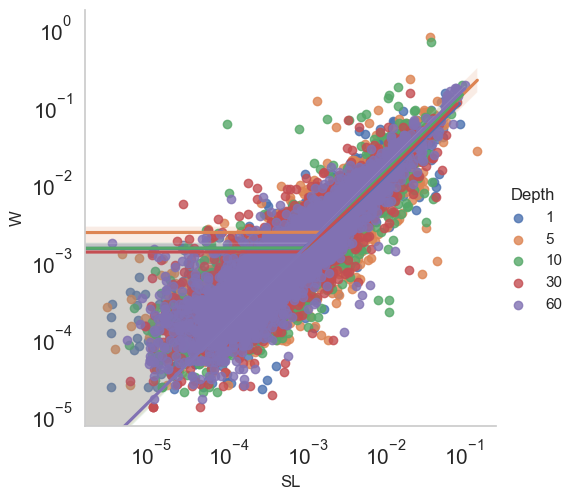

In [188]:
#loglog plot
forpl = newseparated[['ratio', 'feature_id', 'sampleid', 'weekn', 'depth', 'size_code']].copy()
slwplot = forpl.pivot_table(index=["feature_id", "depth", 'weekn'], columns="size_code", values='ratio').fillna(0)
slwplot = slwplot.reset_index()
sns.set_style("whitegrid", {'axes.grid' : False})

slwplot = slwplot.rename(columns={"depth": "Depth"})
ax = sns.lmplot(x="SL", y="W", data=slwplot, hue="Depth");
ax.set(xscale="log", yscale="log")
#ax.axes[0,0].set_xlabel("Defractionated",fontsize=20)
#ax.axes[0,0].set_ylabel("Unfractionated",fontsize=20)
ax.tick_params(labelsize=15)

plt.show()

In [65]:
results

SL         W             L         S
SL  1.000000e+00  0.000180  5.605842e-07  0.010481
W   1.803084e-04  1.000000  4.883656e-02  0.098779
L   5.605842e-07  0.048837  1.000000e+00  0.001461
S   1.048130e-02  0.098779  1.461165e-03  1.000000

In [66]:
#get a list of top taxa
toptaxa = newseparated[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth','weekn', 'Phylum']].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code','Phylum', 'depth']).agg({'feature_frequency':sum})
topd = df_agg['feature_frequency'].groupby(['size_code', 'depth'], group_keys=False).nlargest(10)
topd = topd.to_frame()
topd = topd.reset_index()
listoftop = topd['Phylum'].unique()

#set a palette for the toptaxa
hex_colors_dic = {}
rgb_colors_dic = {}
hex_colors_only = []
for name, hex in matplotlib.colors.cnames.items():
    hex_colors_only.append(hex)
    hex_colors_dic[name] = hex
    rgb_colors_dic[name] = matplotlib.colors.to_rgb(hex)
    
palette_dict = {taxon: color for taxon, color in zip(listoftop, px.colors.sequential.Plasma)}

In [248]:
taxbarplot(newseparated, 'Genus', 10, 50)

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_17466/2998299089.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['date'].str.split('-').str[1]


Components =  2 ;
Total explained variance =  0.71715


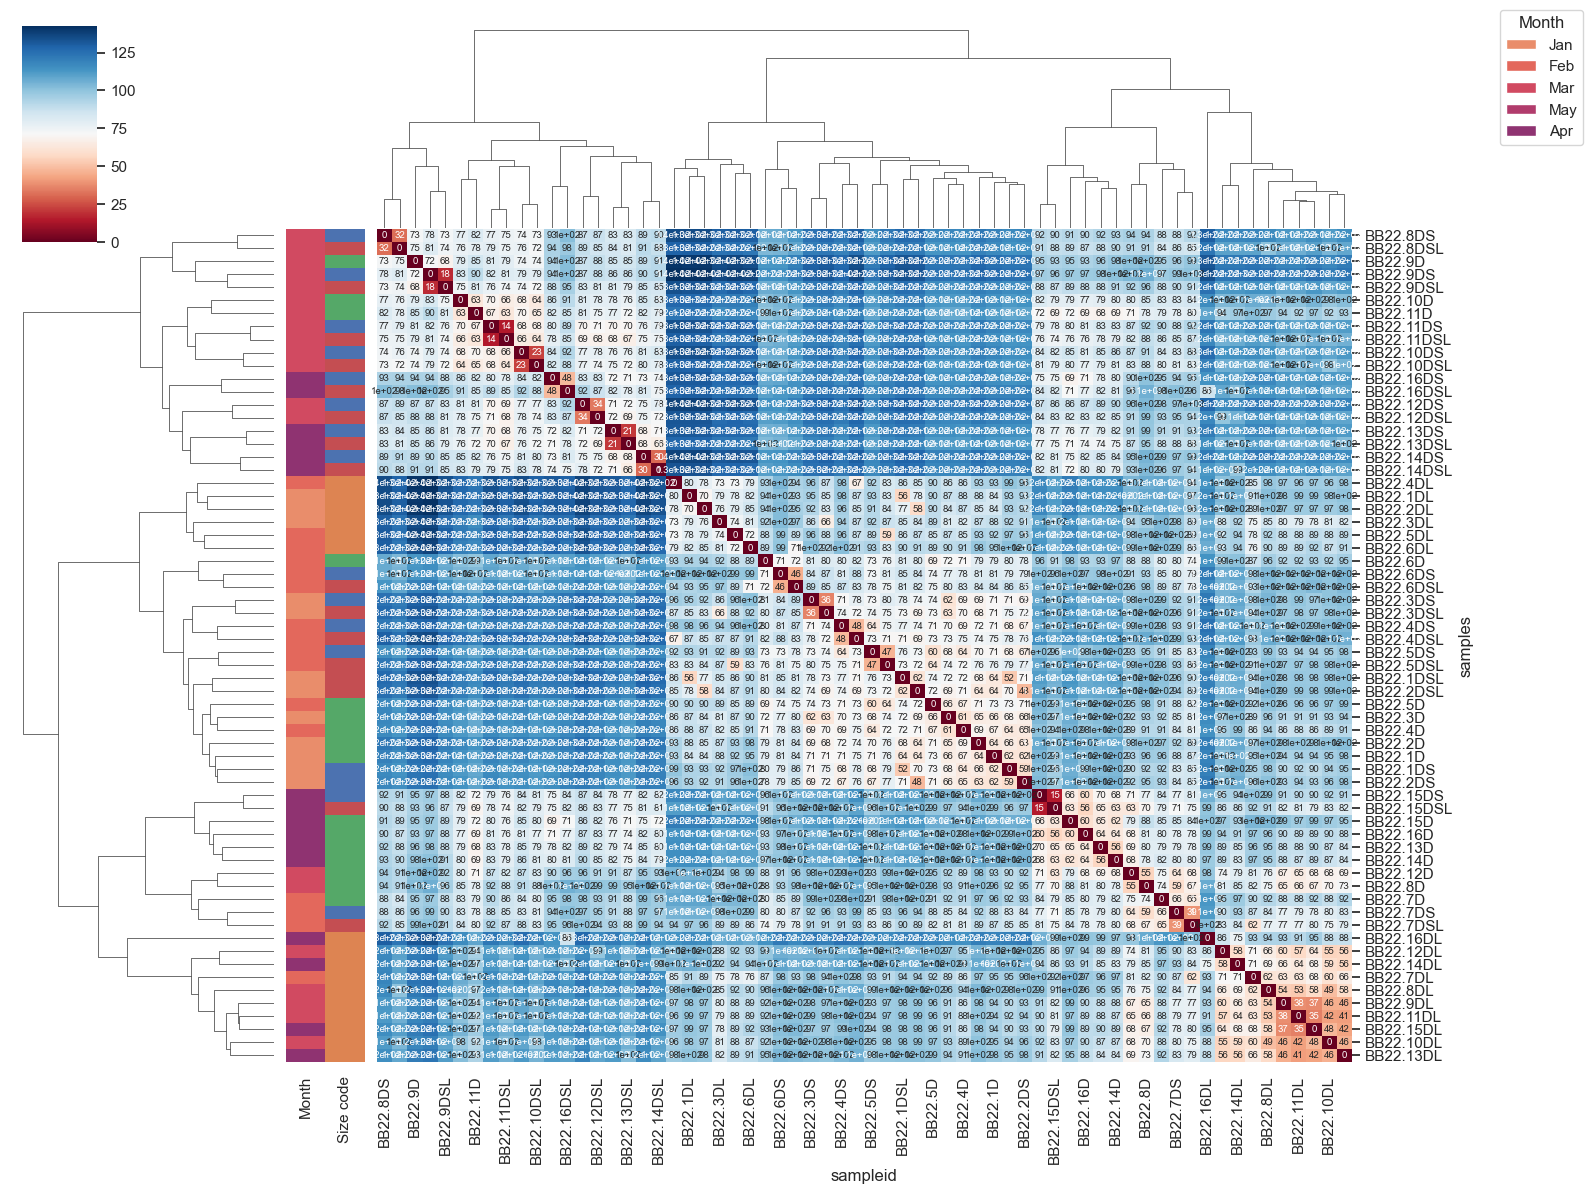

In [82]:
pca, pca_features, sfdclr = pcaplot(newseparated, 60, comm)

In [78]:
pca_features

array([[ 156.90432681,   -2.47200768],
       [ -57.54400805,  142.50842843],
       [ 186.06809455,  -37.07755422],
       [ 176.74262195,  -14.26957039],
       [ 146.42464159,   28.43414158],
       [ -60.66521054,  146.91711857],
       [ 196.08897321,  -33.68801512],
       [ 189.41139055,  -14.62189436],
       [  29.55786434,   96.49524798],
       [ -40.38221917,  114.97731978],
       [ 191.57401227,  -62.5837212 ],
       [ 178.75367887,  -30.93281159],
       [  96.97065093,   47.49314765],
       [ -54.64532933,  142.8427959 ],
       [ 182.03735947,  -42.95054457],
       [ 174.69207145,  -21.12396204],
       [  96.00127007,   51.44916443],
       [ -27.62667773,  111.47919907],
       [ 189.35556063,  -55.05528861],
       [ 178.94049907,  -32.80173178],
       [ 124.72804168,   17.32510539],
       [ -70.81207569,  136.88437978],
       [ 106.7804989 ,   38.87813569],
       [  90.32238277,   65.89918581],
       [  99.82275608,   39.68573144],
       [  -6.38499113,   

In [90]:
level = 'feature_id'
if level == 'feature_id':
    id = 'ASV'
else:
    id = level

subtitile = 'subtitle'

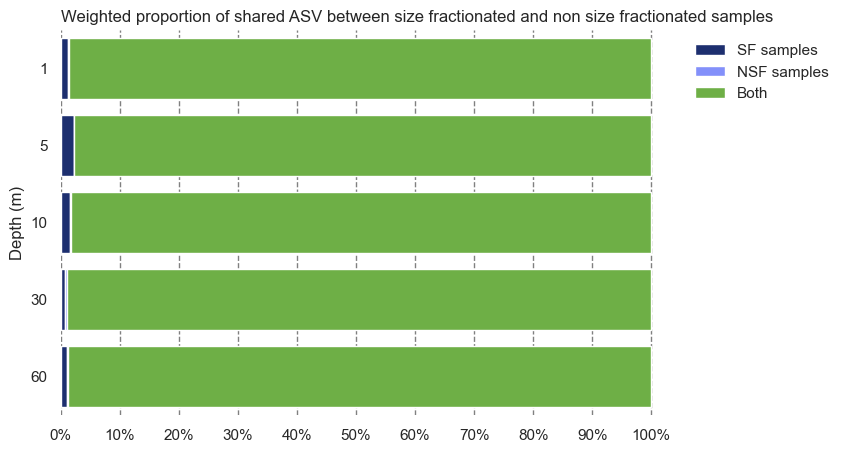

In [93]:
dfplot, level = calcperc(comm, newseparated, level)
# variables
labels = ['SF samples', 'NSF samples','Both']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
title = 'Weighted proportion of shared '+id+' between size fractionated and non size fractionated samples'

plot_stackedbar_p(dfplot, labels, colors, title, subtitle, level)

In [ ]:
dfplot, level = calcperc_defrac(comm, newseparated, level)
# variables
labels = ['SF samples', 'NSF samples','Both', 'DFr']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#de282e']
title = 'Weighted proportion of shared '+id+' between size fractionated and non size fractionated samples'

plot_stackedbar_p(dfplot, labels, colors, title, subtitle, level)

In [ ]:
dfplotSLNSF, dfplot_normalized, level = calcperc_SLNSF(comm, separated, level)
# variables
labels = ['Small size fraction', 'Large size fraction','Both small and large', 'NSF samples']
colors = ['#976BE5','#E56BE5','#941261', '#8390FA']
title = 'Weighted proportion of shared '+ id +' between size fractionated and non size fractionated samples'

plot_stackedbar_p_SLNSF(dfplotSLNSF, labels, colors, title, subtitle, level, 8.1, 2)

In [ ]:
dfplotLSW, dfplot_normalized, level = calcperc_LSW(comm, separated, level)
#variables
labels = ['NSF samples', 'Large and whole','Small and whole', 'Large, small, and whole']
colors = ['#8390FA', '#FF0000', '#DAD746', '#E89618']
title = 'Weighted proportion of shared '+ id +' between size fractionated and non size fractionated samples'

plot_stackedbar_p_SLNSF(dfplotLSW, labels, colors, title, subtitle, level)

In [ ]:
dfplotLS_W, dfplot_normalized, level = calcperc_LS_W(comm, separated, level)
#variables
labels = ['NSF samples', 'Large and whole','Small and whole']
colors = ['#8390FA', '#FF0000', '#DAD746']
title = 'Weighted proportion of shared '+ id +' between size fractionated and non size fractionated samples'

plot_stackedbar_p_SLNSF(dfplotLS_W, labels, colors, title, subtitle, level, 45.1, 5)

** another idea is to run ancom of sizefraction specific and compare after the categories (run ancom on ?time or month.. or some other column) and compare the number/taxonomy of differentially abundant taxa recovered;
are we recovering the same diff ab taxa between the (1.SF samples, 2. NSF samples)

## 18S ANCOM PER DEPTH

In [218]:
pca1_18, pca_features1_18, sfdclr1_18 = pcaplot(newseparated, 1, '18S')
DARejected_SC_taxonomy1_18, prcentile1_18 = run_ancom(newseparated, sfdclr1_18, 1, 'size_code')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



In [223]:
DARejected_SC_taxonomy1_18.sort_values(by='W')

Empty DataFrame
Columns: [W, Reject null hypothesis, feature_id, Confidence, Taxon, Phylum, Class, Family, Genus, Species]
Index: []

In [219]:
pca5_18, pca_features5_18, sfdclr5_18 = pcaplot(newseparated, 5, '18S')
DARejected_SC_taxonomy5_18, prcentile5_18 = run_ancom(newseparated, sfdclr5_18, 5, 'size_code')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



In [225]:
DARejected_SC_taxonomy5_18.sort_values(by='W')

Empty DataFrame
Columns: [W, Reject null hypothesis, feature_id, Confidence, Taxon, Phylum, Class, Family, Genus, Species]
Index: []

In [220]:
pca10_18, pca_features10_18, sfdclr10_18 = pcaplot(newseparated, 10, '18S')
DARejected_SC_taxonomy10_18, prcentile10_18 = run_ancom(newseparated, sfdclr10_18, 10, 'size_code')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



In [226]:
DARejected_SC_taxonomy10_18.sort_values(by='W')

Empty DataFrame
Columns: [W, Reject null hypothesis, feature_id, Confidence, Taxon, Phylum, Class, Family, Genus, Species]
Index: []

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



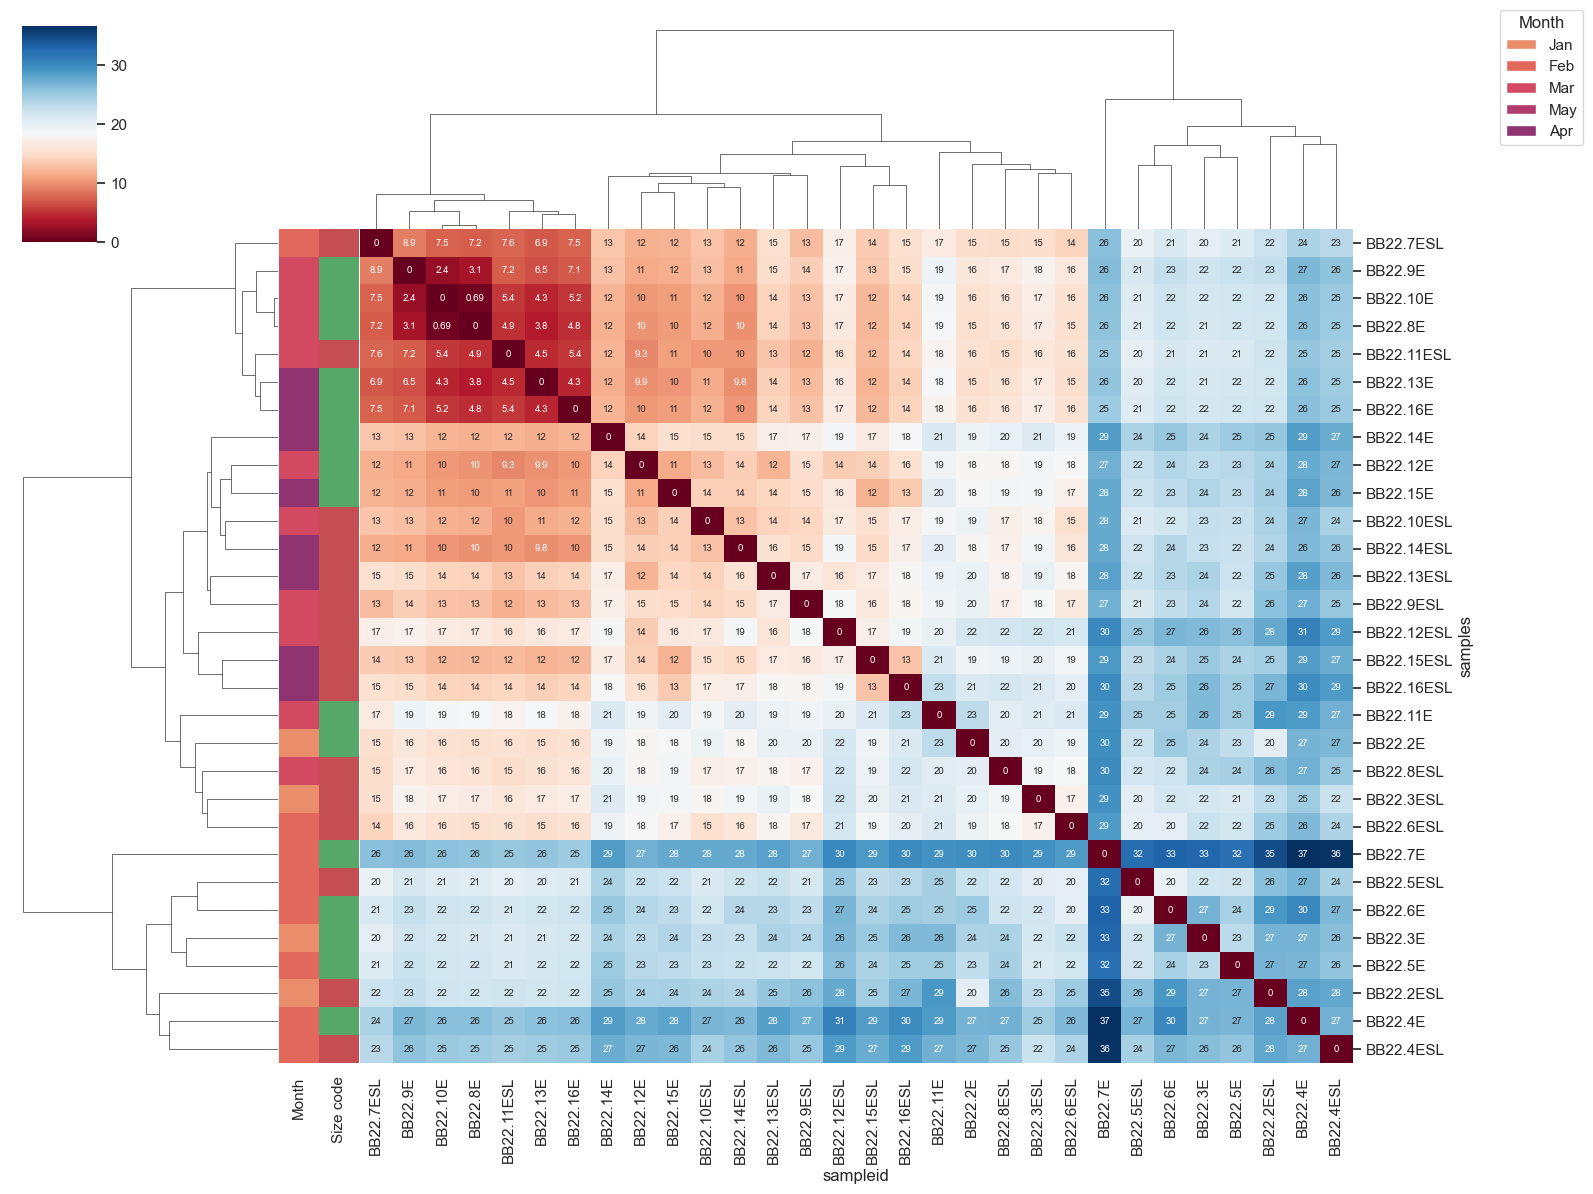

In [221]:
pca30_18, pca_features30_18, sfdclr30_18 = pcaplot(newseparated, 30, '18S')
DARejected_SC_taxonomy30_18, prcentile30_18 = run_ancom(newseparated, sfdclr30_18, 30, 'size_code')

In [227]:
DARejected_SC_taxonomy30_18.sort_values(by='W')

Empty DataFrame
Columns: [W, Reject null hypothesis, feature_id, Confidence, Taxon, Phylum, Class, Family, Genus, Species]
Index: []

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



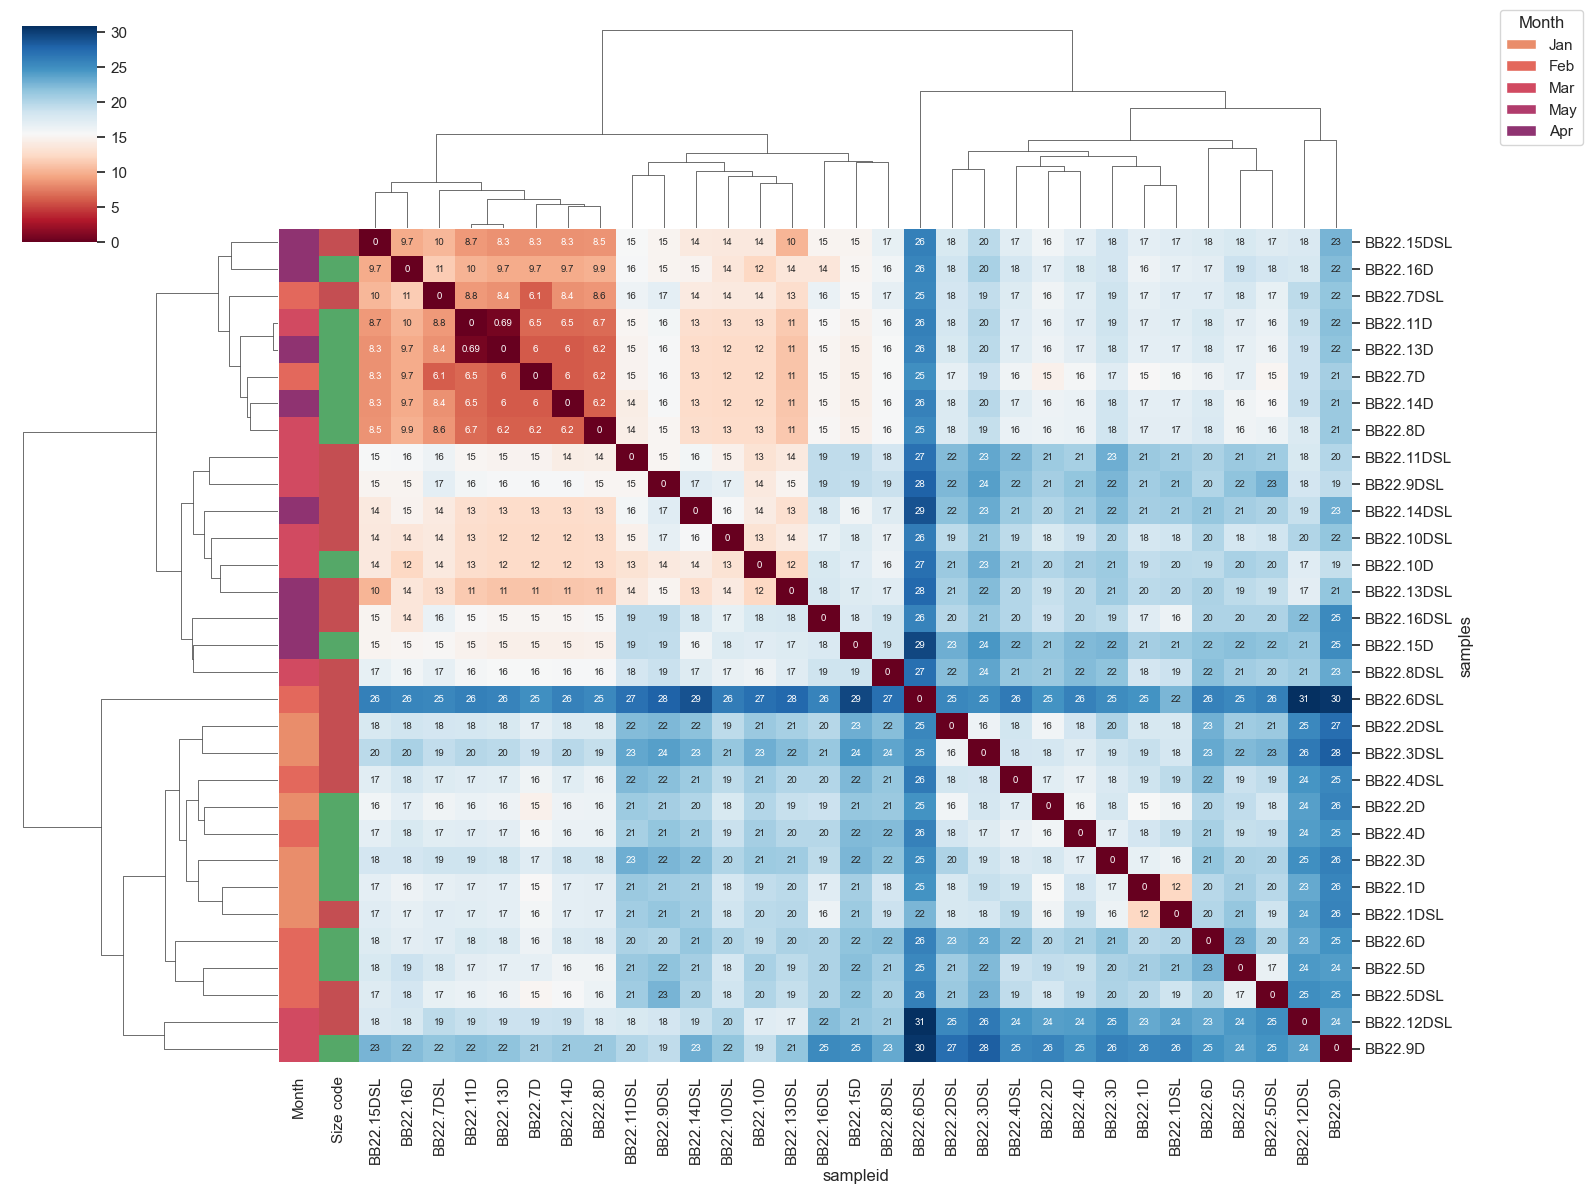

In [222]:
pca60_18, pca_features60_18, sfdclr60_18 = pcaplot(newseparated, 60, '18S')
DARejected_SC_taxonomy60_18, prcentile60_18 = run_ancom(newseparated, sfdclr60_18, 60, 'size_code')

In [228]:
DARejected_SC_taxonomy60_18.sort_values(by='W')

Empty DataFrame
Columns: [W, Reject null hypothesis, feature_id, Confidence, Taxon, Phylum, Class, Family, Genus, Species]
Index: []

## 16S ANCOM PER DEPTH

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



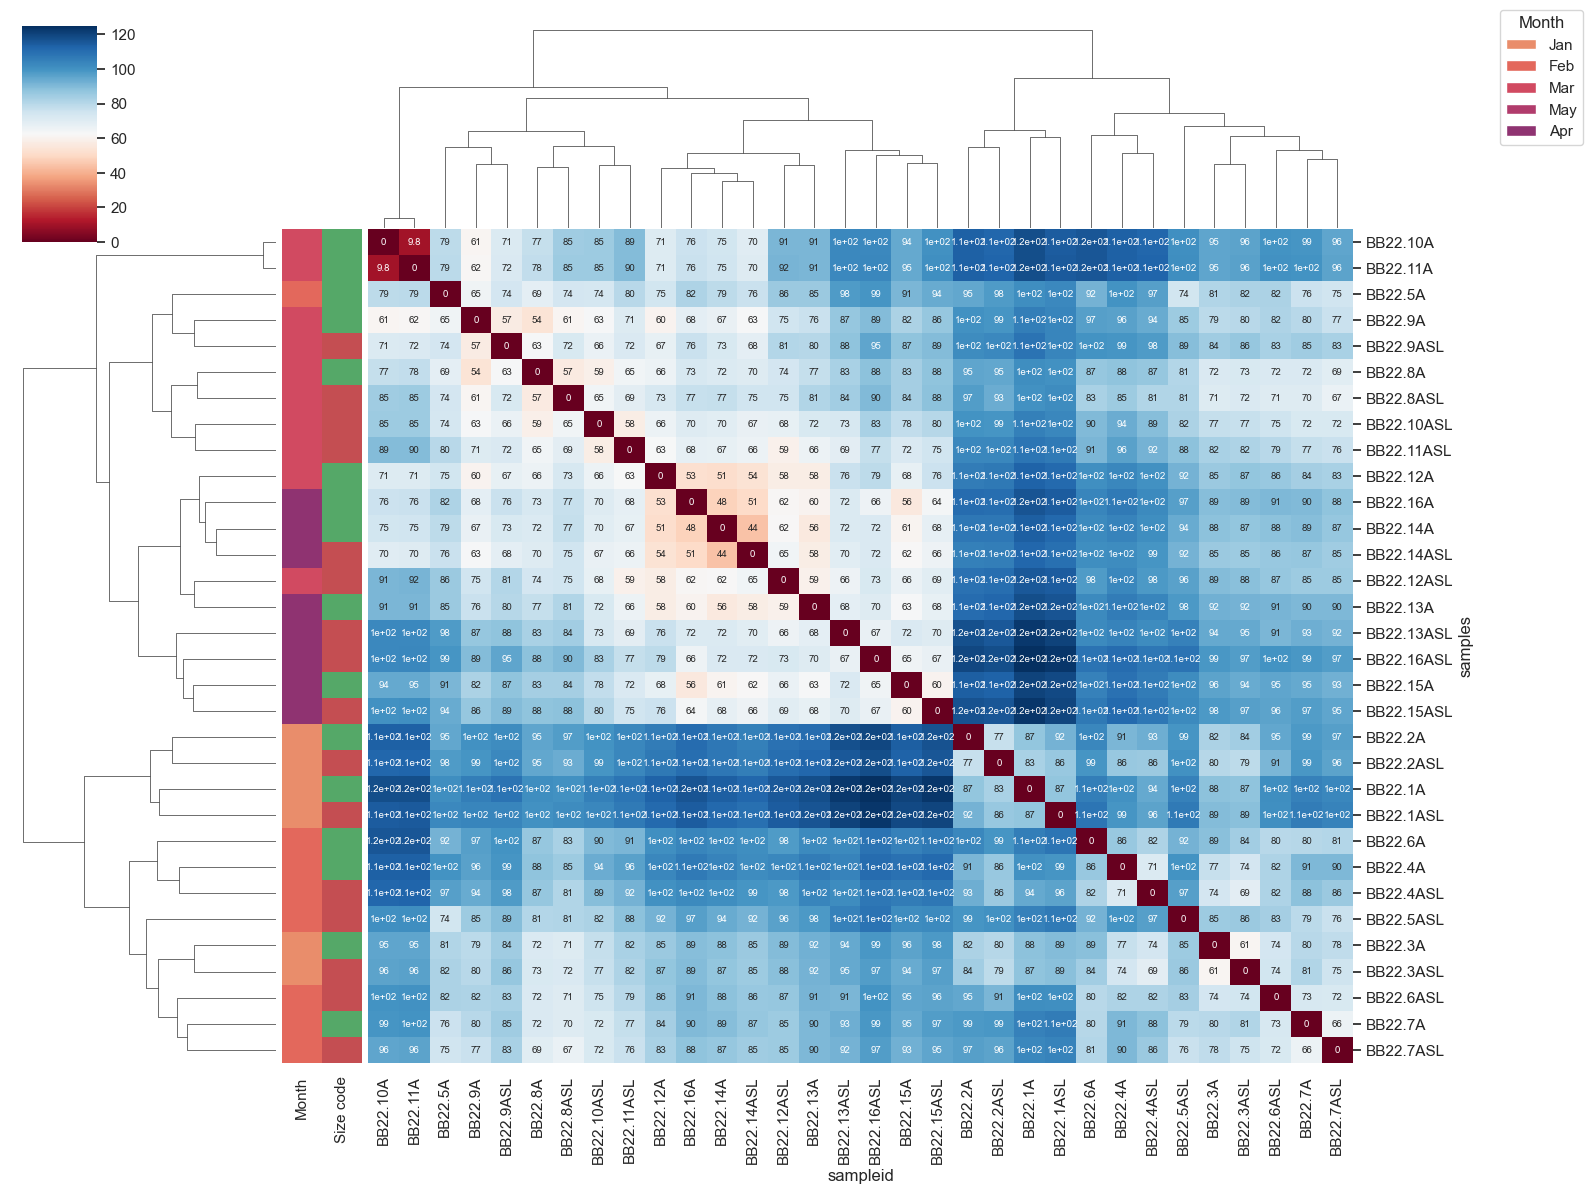

In [235]:
pca1_16, pca_features1_16, sfdclr1_16 = pcaplot(newseparated, 1, '16S')
DARejected_SC_taxonomy1_16, prcentile1_16 = run_ancom(newseparated, sfdclr1_16, 1, 'size_code')

In [177]:
DARejected_SC_taxonomy1.sort_values(by='W')

feature_id     W  Reject null hypothesis  Confidence                                              Taxon             Phylum                   Class             Family       Genus     Species
0  a955e3b357dd61bebe626bf1d0af33c4  1115                    True         1.0  d__Bacteria; p__Proteobacteria; c__Gammaproteo...  p__Proteobacteria  c__Gammaproteobacteria  f__Comamonadaceae  Unassigned  Unassigned

In [236]:
pca5_16, pca_features5_16, sfdclr5_16 = pcaplot(newseparated, 5, '16S')
DARejected_SC_taxonomy5_16, prcentile5_16 = run_ancom(newseparated, sfdclr5_16, 5, 'size_code')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



In [176]:
DARejected_SC_taxonomy5.sort_values(by='W')

feature_id     W  Reject null hypothesis  Confidence                                              Taxon             Phylum                   Class       Family        Genus     Species
0  50a0c3221c68046dfc96e032aff1ccd8  1250                    True    0.827567  d__Bacteria; p__Proteobacteria; c__Alphaproteo...  p__Proteobacteria  c__Alphaproteobacteria  f__Clade_II  g__Clade_II  Unassigned

In [237]:
pca10_16, pca_features10_16, sfdclr10_16 = pcaplot(newseparated, 10, '16S')
DARejected_SC_taxonomy10_16, prcentile10_16 = run_ancom(newseparated, sfdclr10_16, 10, 'size_code')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



In [178]:
DARejected_SC_taxonomy10.sort_values(by='W')

feature_id    W  Reject null hypothesis  Confidence                                              Taxon               Phylum                   Class                 Family              Genus                            Species
0     0024026291e1a36a04810106884d6ce5    0                    True    0.996856  d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...      p__Bacteroidota          c__Bacteroidia      f__Cryomorphaceae    g__Luteibaculum                         Unassigned
1573  a57f5e864ea13459ec15f6024fb15be4    0                    True    1.000000  d__Bacteria; p__Campylobacterota; c__Campyloba...  p__Campylobacterota      c__Campylobacteria       f__Sulfurovaceae      g__Sulfurovum                         Unassigned
1572  a5779fa41701e82a4f5a41edc3187610    0                    True    0.999985  d__Bacteria; p__Actinobacteriota; c__Actinobac...  p__Actinobacteriota       c__Actinobacteria  f__Pseudonocardiaceae  g__Pseudonocardia                         Unassigned
1571  a502ca1686ec62732d8e04b545193526    0                    True    0.955818  d__Bacteria; p__Desulfobacterota; c__Desulfoba...  p__Desulfobacterota      c__Desulfobacteria  f__Desulfobacteraceae      g__uncultured            s__uncultured_bacterium
1570  a4ef7821bc0a6b157aa4cc812110f204    0                    True    0.905672  d__Bacteria; p__Proteobacteria; c__Alphaproteo...    p__Proteobacteria  c__Alphaproteobacteria          f__uncultured      g__uncultured  s__uncultured_Alphaproteobacteria
...                                ...  ...                     ...         ...                                                ...                  ...                     ...                    ...                ...                                ...
750   4f171b2257a664ed7148e94ce05ad87c   85                    True    1.000000  d__Bacteria; p__Planctomycetota; c__Phycisphae...   p__Planctomycetota        c__Phycisphaerae    f__Phycisphaeraceae     g__JL-ETNP-F27                         Unassigned
432   2dbeb9e3b59e5bfd1c008959d535fd97  141                    True    0.987640  d__Bacteria; p__Proteobacteria; c__Alphaproteo...    p__Proteobacteria  c__Alphaproteobacteria            f__Clade_II        g__Clade_II                         Unassigned
1787  bbb42dea9e3dd117eeb07d7eb1770031  167                    True    0.999936  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    p__Proteobacteria  c__Gammaproteobacteria      f__Thiotrichaceae      g__uncultured               s__uncultured_marine
1695  b43e2e7c8457ab602da3de2fc739d767  217                    True    0.958054  d__Bacteria; p__Planctomycetota; c__OM190; o__...   p__Planctomycetota                c__OM190               f__OM190           g__OM190        s__uncultured_planctomycete
1154  79034543545874704961c1c87f21c127  300                    True    0.999998  d__Bacteria; p__Proteobacteria; c__Gammaproteo...    p__Proteobacteria  c__Gammaproteobacteria          f__Halieaceae         Unassigned                         Unassigned

[2477 rows x 10 columns]

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



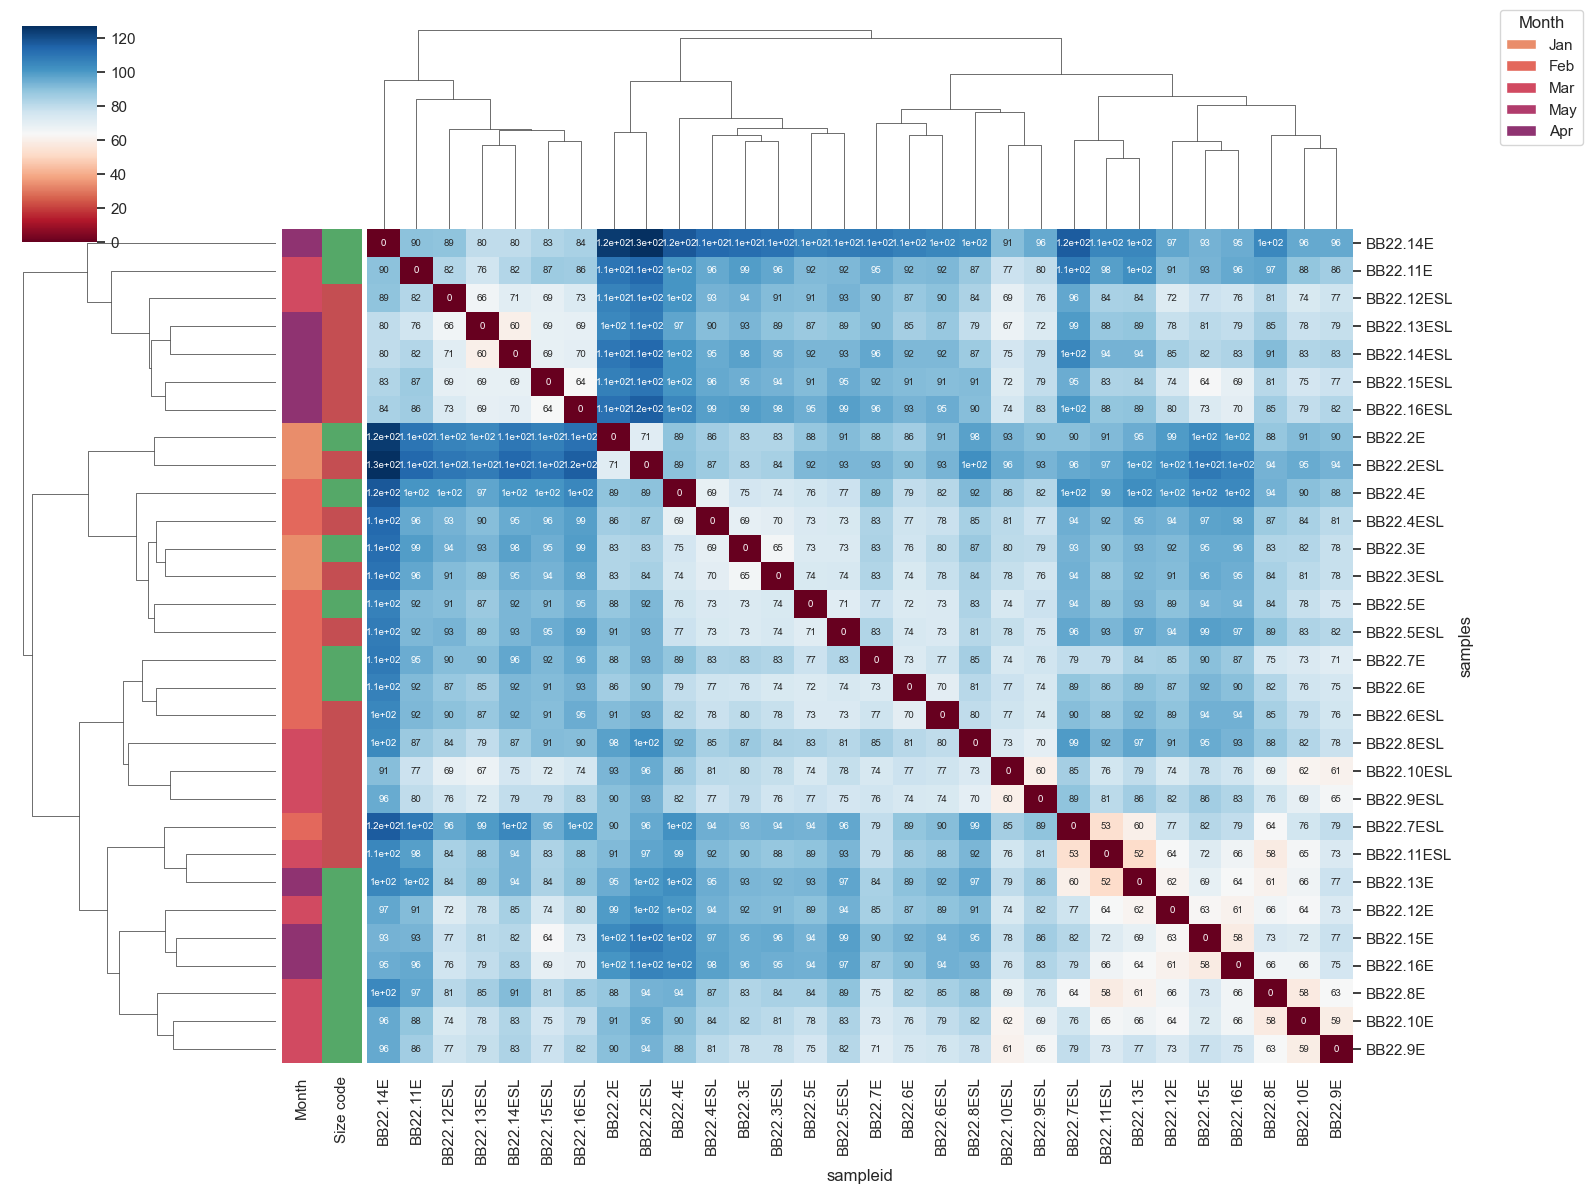

In [238]:
pca30_16, pca_features30_16, sfdclr30_16 = pcaplot(newseparated, 30, '16S')
DARejected_SC_taxonomy30_16, prcentile30_16 = run_ancom(newseparated, sfdclr30_16, 30, 'size_code')

In [179]:
DARejected_SC_taxonomy30.sort_values(by='W')

Empty DataFrame
Columns: [W, Reject null hypothesis, feature_id, Confidence, Taxon, Phylum, Class, Family, Genus, Species]
Index: []

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/4130031698.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Diana/mambaforge/envs/qiime2-2023.5/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3659: F_onewayConstantInputWarning:

Each of the input arrays is constant;the F statistic is not defined or infinite



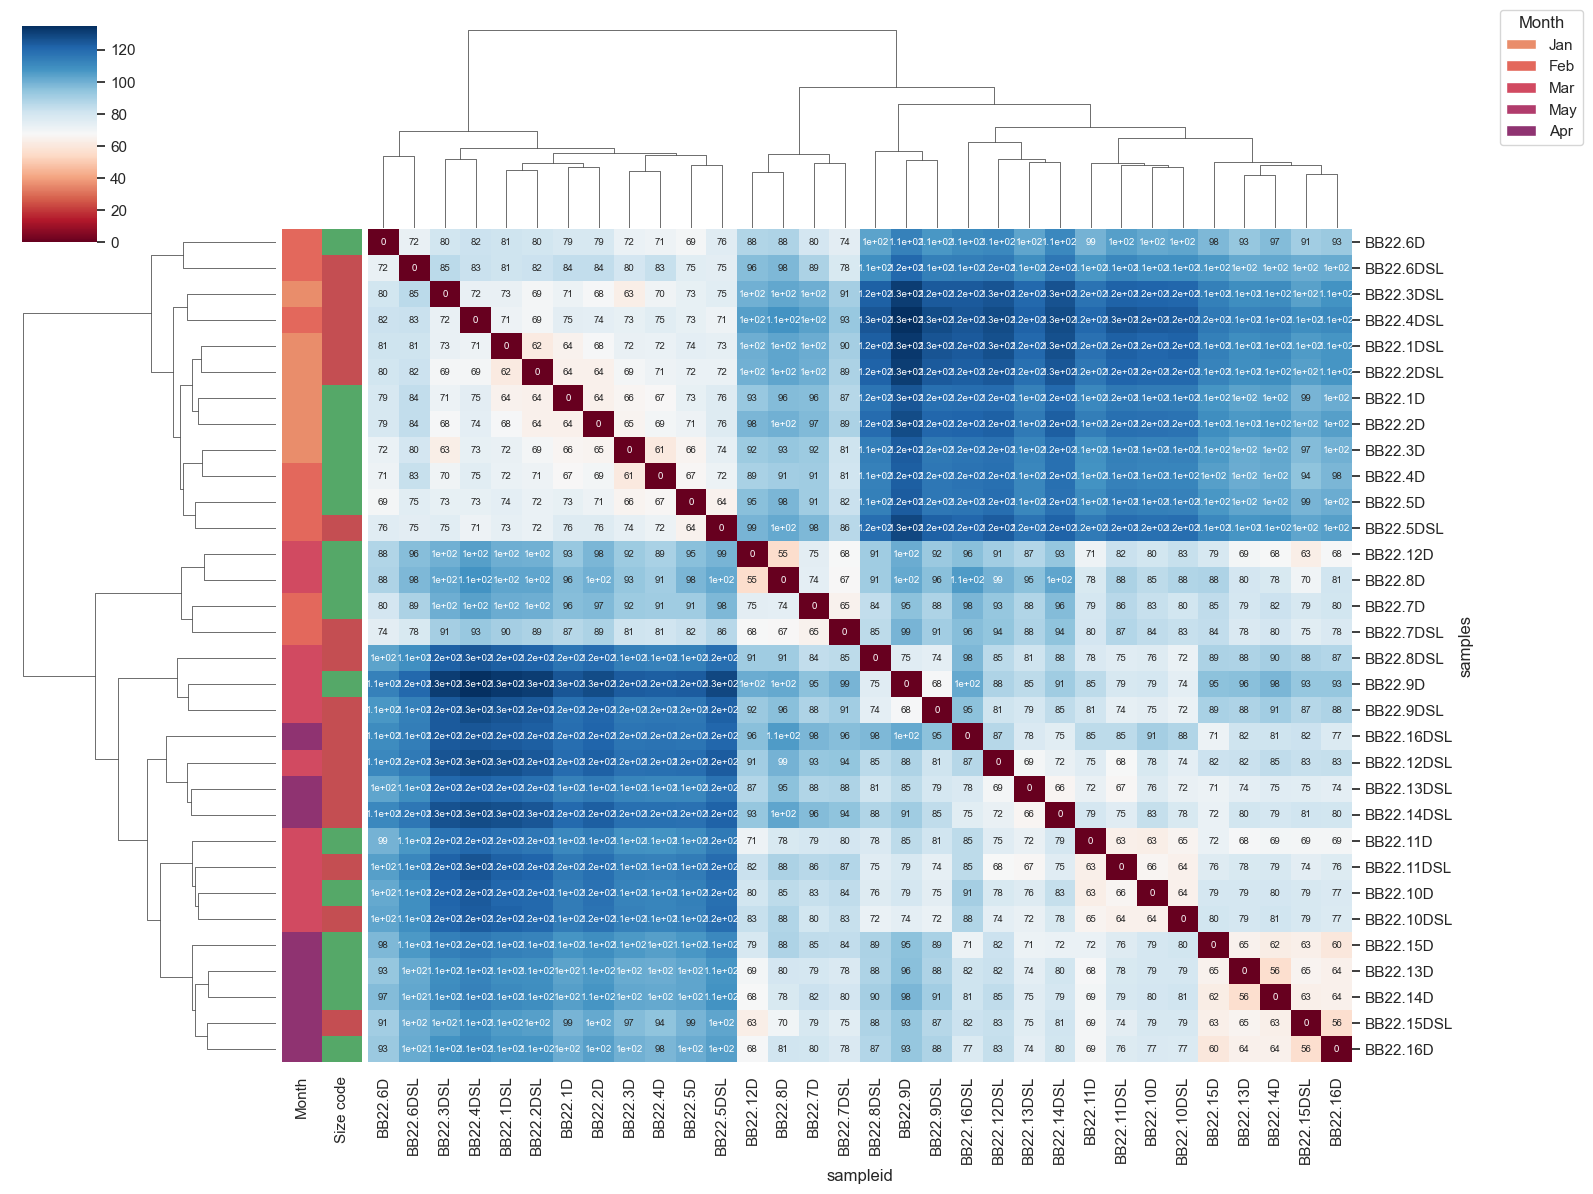

In [239]:
pca60_16, pca_features60_16, sfdclr60_16 = pcaplot(newseparated, 60, '16S')
DARejected_SC_taxonomy60_16, prcentile60__16 = run_ancom(newseparated, sfdclr60_16, 60, 'size_code')

In [240]:
DARejected_SC_taxonomy60_16.sort_values(by='W')

feature_id     W  Reject null hypothesis  Confidence                                              Taxon             Phylum                   Class            Family         Genus           Species
0  8c21844441c36ccd50e40d83874ef72e  1601                    True    0.720662  d__Bacteria; p__Proteobacteria; c__Gammaproteo...  p__Proteobacteria  c__Gammaproteobacteria  f__Moritellaceae  g__Moritella  s__Moritella_sp.

? run a clustermap of top10 taxa of each deapth and color rows by depth, month, size code

In [242]:
prcentile60__16

Percentile                       0.0       25.0      50.0      75.0       100.0 0.0   25.0  50.0   75.0  100.0
Group                               SL        SL        SL        SL         SL     W     W     W      W     W
feature_id                                                                                                    
0024026291e1a36a04810106884d6ce5   0.1  0.100000  0.100000  0.100000   1.666667   0.1   0.1   0.1  0.100   2.0
0044164f6d463942dca822a22c7c6f4d   0.1  0.100000  0.100000  0.100000   0.100000   0.1   0.1   0.1  0.100   2.0
004fddfa331355466f056bfd5ef0cae9   0.1  0.100000  0.100000  0.100000   4.428030   0.1   0.1   0.1  0.100   6.0
0089c2ee62e4e072faf4a080fc7ae6e5   0.1  1.235255  3.625377  9.611547  20.884726   0.1   0.1   2.5  4.000   7.0
008d11c0689fd62d7a19f9e1fbb54268   0.1  0.100000  0.100000  3.425926  11.386364   0.1   0.1   0.1  0.825   8.0
...                                ...       ...       ...       ...        ...   ...   ...   ...    ...   ...
ffb0f612bb069da34d387b1a853181f5   0.1  0.100000  0.100000  0.100000   0.100000   0.1   0.1   0.1  0.100   4.0
ffbd54eab7361aaf1a40762c62fabf95   0.1  0.100000  0.100000  0.100000   0.100000   0.1   0.1   0.1  0.100   2.0
ffe894310e490a399f103ccf919dd489   0.1  0.100000  0.100000  8.229295  29.922414   0.1   0.1   0.1  2.075  22.0
ffec0d080d61f2b82dde351ab6f0a910   0.1  0.100000  0.100000  0.100000  20.155000   0.1   0.1   0.1  0.100  12.0
ffff59853df9ae7b03cfc0ca533fc40b   0.1  0.100000  0.100000  0.100000   3.017341   0.1   0.1   0.1  0.100   0.1

[2586 rows x 10 columns]

In [ ]:
pca, pca_features, sfdclr = pcaplot(separated, 1, '16S')
DARejected_month_taxonomy_16_1, prcentile = run_ancom(sfdclr, 1, 'Month')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/1916416206.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/1916416206.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_46628/1916416206.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

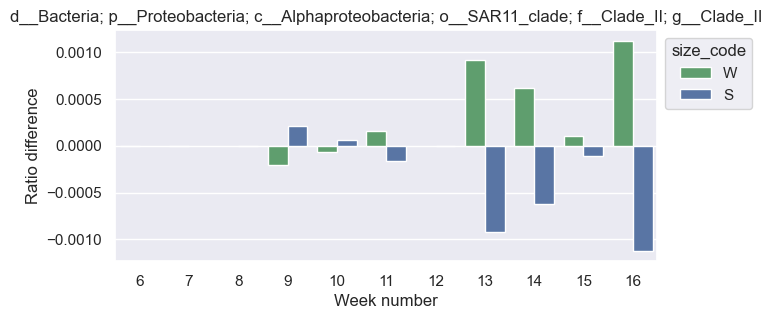

In [184]:
plot_per_fid('16S', separated, 60, '50a0c3221c68046dfc96e032aff1ccd8')

In [ ]:
plot_df2.sort_values('dim1')

### Upset plot data prep

In [ ]:
upsetprep('16S', 'Genus')

In [ ]:
#if we want to make an upset plot of all depths?

frames = sfd1, sfd5, sfd10, sfd30, sfd60
result = pd.concat(frames)
resultpivot = result.pivot_table(index='Genus', columns='set_name', values='feature_frequency')
resultpivot = resultpivot.fillna(0)
resultpivot[resultpivot != 0] = 1
tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
tosave.to_csv('genus_all16S_relab.csv')

### Venn diagrams

In [ ]:
#Depth 1 all 16S at genus level
#N=84
venn3(subsets = (27, 11, 4, 7, 6, 5, 22), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);
#venn3(subsets = (Lonly, Sonly, LS, Wonly, LW, SW, LSW), set_labels = ('Large >3μm', 'Small 3-02μm', 'Whole water <0.22μm'), alpha = 0.5);

plt.title("1m depth") 
plt.savefig("outputs/02-EUKs/D1_genus_venn.png")
plt.show()

In [ ]:
lm = sfa.ols('nASVs ~ C(size_code)', data=sfd_LM).fit()
anova = sa.stats.anova_lm(lm)
sp.posthoc_ttest(sfd_LM, val_col='nASVs', group_col='size_code', p_adjust='holm')

In [ ]:
sfd_S = sfd[['size_code', 'nASVs', 'weekn']].copy()
sfd_S = sfd_S.drop_duplicates()
sdfpv = sfd_S.pivot(index='weekn', columns='size_code', values='nASVs')
fvalue, pvalue = stats.f_oneway(sdfpv['L'], sdfpv['S'], sdfpv['W'])

In [ ]:
sfd_LM = sfd[['size_code', 'nASVs']].copy()
sfd_LM = sfd_LM.drop_duplicates()
lm = sfa.ols('nASVs ~ C(size_code)', data=sfd_LM).fit()
anova = sa.stats.anova_lm(lm)
sp.posthoc_ttest(sfd_LM, val_col='nASVs', group_col='size_code', p_adjust='holm')

In [ ]:
dffff = sp.posthoc_ttest(sfd_LM, val_col='nASVs', group_col='size_code', p_adjust='holm')
dffff

In [ ]:
sfd_S = sfd_S.drop_duplicates()

In [ ]:
sfd_S = sfd_S.set_index('weekn')

In [ ]:
sfd_sdf = sfd_S.stack().to_frame().reset_index()

In [ ]:
sdfpv = sfd_S.pivot(index='weekn', columns='size_code', values='nASVs')

In [ ]:
sdfpv

In [ ]:
fvalue, pvalue = stats.f_oneway(sdfpv['L'], sdfpv['S'], sdfpv['W'])

In [ ]:
pvalue

In [ ]:
plot_stackedbar_p(dfplot, labels, colors, title, subtitle)

In [ ]:
plt.savefig('outputs/'+comm_id+'/D'+str(depth)+'_adlineplot.png', dpi=200, bbox_inches="tight")

In [ ]:
df_grouped.describe()

In [ ]:
##make new category of S+L

In [220]:
#make sure all size codes are indicated
all_md["size_code"] = all_md["sampleid"].str.extract(r'[1-9][0-9]?[A-E]([L-S])')
all_md["size_code"] = all_md["size_code"].fillna('W')

#only keep values from weeks 1 to 16
sep_SL = all_md[all_md.size_code != "W"]
sep_SL = sep_SL.drop(sep_SL[sep_SL.weekn > 16].index)

#sum [DNA] of small and large size fractions
sep_SL['[DNAt]'] = sep_SL.groupby(['weekn', 'depth'])['[DNA]ng/ul'].transform('sum')

#separate small and size fraction
sep_S = sep_SL[sep_SL.size_code == 'S']
sep_L = sep_SL[sep_SL.size_code == 'L']

#calculate DNA proportion per size fraction
sep_SL['DNApr'] = sep_SL['[DNA]ng/ul']/sep_SL['[DNAt]']

#merge with separated on common columns to get corresponding rel. abundances
sep_SL = sep_SL[['sampleid', 'DNApr', '[DNAt]']].copy()
sepSLRA = pd.merge(separated, sep_SL, on=['sampleid'], how='left') #all_md is the metadata file

#exclude ASVs from the whole water
sep_SLRA = sepSLRA[separated.size_code != "W"]

#calculate corrected per sample ratio, and corrected feature frequency of de-fractionated samples
sep_SLRA['Newfeature_frequency'] = sep_SLRA['feature_frequency'] * sep_SLRA['DNApr']
sep_SLRA['Newff'] = sep_SLRA.groupby(['feature_id', 'weekn', 'depth'])['Newfeature_frequency'].transform('sum')


#sep_SLRA = sep_SLRA.drop(['sampleid', 'size_code'], axis=1)
#sep_SLRA['sampleid'] = "BB22." + sep_SLRA['weekn'].astype(str) + sep_SLRA['depth_code'] + "SL"

#uncomment the line below if keeping small and large original sample
#sep_SLRA['size_code'] = sep_SLRA['size_code'] + '-DFr'

#uncomment the line above if merging smallandlarge
#sep_SLRA['size_code'] = 'SL'

sep_SLRA = sep_SLRA.drop(['feature_frequency', 'Total', 'ratio', 'nASVs', 'weekdepth', 'avg',
                          'diff', 'extraction_date', '[DNA]ng/ul', 'A260/280', 'A260/230',
                          'Newfeature_frequency'], axis=1)
sep_SLRA.rename(columns={'Newff':'feature_frequency'}, inplace=True)
sep_SLRA = sep_SLRA.drop_duplicates()

sep_SLRA['Total'] = sep_SLRA['feature_frequency'].groupby(sep_SLRA['sampleid']).transform('sum')
sep_SLRA['ratio'] = sep_SLRA['feature_frequency']/sep_SLRA['Total']
sep_SLRA['nASVs'] = sep_SLRA['feature_id'].groupby(sep_SLRA['sampleid']).transform('nunique')

sep_SLRA = sep_SLRA.drop_duplicates()

sep_WO = separated[separated.size_code == "W"]
sep_L = separated[separated.size_code == "L"]
sep_S = separated[separated.size_code == "S"]

newseparated = pd.concat([sep_SLRA, sep_WO], ignore_index=True)

newseparated['weekdepth'] = newseparated["weekn"].astype(str) + newseparated["depth"].astype(str)
newseparated['avg'] = newseparated['nASVs'].groupby(newseparated['weekdepth']).transform('mean')
newseparated['diff'] = newseparated['nASVs'] - newseparated['avg']

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_3978/1756682031.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_SLRA['Newfeature_frequency'] = sep_SLRA['feature_frequency'] * sep_SLRA['DNApr']
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_3978/1756682031.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_SLRA['Newff'] = sep_SLRA.groupby(['feature_id', 'weekn', 'depth'])['Newfeature_frequency'].transform('sum')
